In this tutorial, we show how to use RipsNet to learn the topology of very simple synthetic data sets comprised of (noisy) circles. Let's first define the seed (for reproducibility), the number of point clouds that we will use for training RipsNet, the number of point clouds we will use to test it, the cardinality of the point clouds and finally the amount of corrupted points (when noise is added).

In [2]:
N_sets_train = 900  # Number of train point clouds
N_sets_test  = 300  # Number of test  point clouds
N_points     = 600  # Point cloud cardinality
N_noise      = 200  # Number of corrupted points

## Initialization

### Imports


In [3]:
!pip install gudhi tqdm matplotlib scikit-learn scipy torch xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 22.4 MB/s eta 0:00:00


In [4]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import gudhi as gd
from gudhi.representations import DiagramSelector, Landscape, PersistenceImage
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.optim import Adamax
from xgboost import XGBClassifier

###utils


#### Layer definitions

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adamax

class DenseRagged(nn.Module):
    def __init__(self, in_features=None, out_features=30, activation='relu', use_bias=True):
        super(DenseRagged, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.use_bias = use_bias
        self.activation = activation

        self.weight = None
        self.bias = None

    def forward(self, inputs):
        outputs = []
        for x in inputs:
            if self.weight is None:
                in_features = x.shape[-1]
                self.weight = nn.Parameter(torch.randn(in_features, self.out_features) * 0.01)
                if self.use_bias:
                    self.bias = nn.Parameter(torch.zeros(self.out_features))
            y = torch.matmul(x, self.weight)
            if self.use_bias:
                y = y + self.bias
            if self.activation == 'relu':
                y = F.relu(y)
            elif self.activation == 'sigmoid':
                y = torch.sigmoid(y)
            elif self.activation == 'tanh':
                y = torch.tanh(y)
            outputs.append(y)
        return outputs


class PermopRagged(nn.Module):
    def forward(self, inputs):
        return torch.stack([torch.sum(x, dim=0) for x in inputs])


class RaggedPersistenceModel(nn.Module):
    def __init__(self, output_dim):
        super(RaggedPersistenceModel, self).__init__()
        self.ragged_layers = nn.ModuleList([
            DenseRagged(out_features=30, activation='relu'),
            DenseRagged(out_features=20, activation='relu'),
            DenseRagged(out_features=10, activation='relu')
        ])
        self.perm = PermopRagged()

        self.fc = nn.Sequential(
            nn.Linear(10, 50),
            nn.ReLU(),
            nn.Linear(50, 100),
            nn.ReLU(),
            nn.Linear(100, 200),
            nn.ReLU(),
            nn.Linear(200, output_dim),
            nn.Sigmoid()
        )

    def forward(self, inputs):
        x = inputs
        for layer in self.ragged_layers:
            x = layer(x)
        x = self.perm(x)
        x = self.fc(x)
        return x

#### Point Cloud

In [6]:
import numpy as np
from tqdm import tqdm
import gudhi as gd


####################################
###  Creation of point clouds    ###
####################################

def create_circle(N_points, r, x_0, y_0):
    X = []
    for i in range(N_points):
        theta = np.random.uniform() * 2 * np.pi
        X.append([(r * np.cos(theta)) + x_0, (r * np.sin(theta) + y_0)])
    return np.array(X)


def create_1_circle_clean(N_points):
    r = 2
    x_0, y_0 = 10 * np.random.rand() - 5, 10 * np.random.rand() - 5
    return create_circle(N_points, r, x_0, y_0)


def create_2_circle_clean(N_points):
    r1 = 5
    r2 = 3
    x_0, y_0 = 30 * np.random.rand() - 15, 30 * np.random.rand() - 15
    x_1, y_1 = 30 * np.random.rand() - 15, 30 * np.random.rand() - 15
    while np.sqrt((x_0 - x_1) ** 2 + (y_0 - y_1) ** 2) <= r1 + r2:
        x_1, y_1 = 30 * np.random.rand() - 15, 30 * np.random.rand() - 15
    circle1 = create_circle(N_points // 2, r1, x_0, y_0)
    circle2 = create_circle(N_points - N_points // 2, r2, x_1, y_1)
    X = [0] * N_points
    X[:N_points // 2] = circle1
    X[N_points // 2:] = circle2
    np.random.shuffle(X)
    return np.array(X)


def create_3_circle_clean(N_points):
    r0 = 5
    r1 = 3
    r2 = 2
    x_0, y_0 = 30 * np.random.rand() - 15, 30 * np.random.rand() - 15
    x_1, y_1 = 30 * np.random.rand() - 15, 30 * np.random.rand() - 15
    while np.sqrt((x_0 - x_1) ** 2 + (y_0 - y_1) ** 2) <= r0 + r1:
        x_1, y_1 = 30 * np.random.rand() - 15, 30 * np.random.rand() - 15

    x_2, y_2 = 30 * np.random.rand() - 15, 30 * np.random.rand() - 15
    while(np.sqrt((x_0 - x_2)**2 + (y_0 - y_2)**2) <= r0 + r2) or (np.sqrt((x_1 - x_2)**2 + (y_1 - y_2)**2) <= r1 + r2):
        x_2, y_2 = 30 * np.random.rand() - 15, 30 * np.random.rand() - 15

    circle0 = create_circle(N_points // 3, r0, x_0, y_0)
    circle1 = create_circle(N_points // 3, r1, x_1, y_1)
    circle2 = create_circle(N_points // 3, r2, x_2, y_2)

    # Handler in case N_points mod 3 != 0.
    true_N_points = 3 * (N_points // 3)

    X = [[0,0]] * true_N_points
    X[:true_N_points // 3] = circle0
    X[true_N_points // 3:2 * true_N_points // 3] = circle1
    X[2 * true_N_points // 3:] = circle2
    np.random.shuffle(X)
    return np.array(X)


def create_1_circle_noisy(N_points, N_noise):
    r = 2
    x_0, y_0 = 10 * np.random.rand() - 5, 10 * np.random.rand() - 5
    X = create_circle(N_points, r, x_0, y_0)
    noise = []
    for i in range(N_noise):
        noise.append([np.random.uniform(x_0 - r, x_0 + r),
                      np.random.uniform(y_0 - r, y_0 + r)])
    X = np.array(X)
    X[np.random.choice(np.arange(len(X)), size=N_noise, replace=False, p=None)] = np.array(noise)
    return X


def create_2_circle_noisy(N_points, N_noise):
    r1 = 5
    r2 = 3
    x_0, y_0 = 30 * np.random.rand() - 15, 30 * np.random.rand() - 15
    x_1, y_1 = 30 * np.random.rand() - 15, 30 * np.random.rand() - 15
    while(np.sqrt((x_0 - x_1)**2 + (y_0 - y_1)**2) <= r1 + r2):
        x_1, y_1 = 30 * np.random.rand() - 15, 30 * np.random.rand() - 15
    circle1 = create_circle(N_points // 2, r1, x_0, y_0)
    circle2 = create_circle(N_points - N_points // 2, r2, x_1, y_1)
    X = [0] * N_points
    X[:N_points // 2] = circle1
    X[N_points // 2:] = circle2
    np.random.shuffle(X)
    noise = []
    for i in range(N_noise):
        noise.append([np.random.uniform(min(x_0 - r1, x_1 - r2), max(x_0 + r1, x_1 + r2)),
                      np.random.uniform(min(y_0 - r1, y_1 - r2), max(y_0 + r1, y_1 + r2))])
    X = np.array(X)
    X[np.random.choice(np.arange(len(X)), size=N_noise, replace=False, p=None)] = np.array(noise)
    return X


def create_3_circle_noisy(N_points, N_noise):
    r0 = 5
    r1 = 3
    r2 = 2
    x_0, y_0 = 30 * np.random.rand() - 15, 30 * np.random.rand() - 15
    x_1, y_1 = 30 * np.random.rand() - 15, 30 * np.random.rand() - 15
    while np.sqrt((x_0 - x_1) ** 2 + (y_0 - y_1) ** 2) <= r0 + r1:
        x_1, y_1 = 30 * np.random.rand() - 15, 30 * np.random.rand() - 15
    x_2, y_2 = 30 * np.random.rand() - 15, 30 * np.random.rand() - 15
    while(np.sqrt((x_0 - x_2)**2 + (y_0 - y_2)**2) <= r0 + r2) or (np.sqrt((x_1 - x_2)**2 + (y_1 - y_2)**2) <= r1 + r2):
        x_2, y_2 = 30 * np.random.rand() - 15, 30 * np.random.rand() - 15
    circle0 = create_circle(N_points // 3, r0, x_0, y_0)
    circle1 = create_circle(N_points // 3, r1, x_1, y_1)
    circle2 = create_circle(N_points // 3, r2, x_2, y_2)

    true_N_points = 3 * (N_points // 3)
    X = [[0,0]] * true_N_points
    X[:true_N_points // 3] = circle0
    X[true_N_points // 3:2 * true_N_points // 3] = circle1
    X[2 * true_N_points // 3:] = circle2

    np.random.shuffle(X)
    noise = []
    for i in range(N_noise):
        noise.append([np.random.uniform(np.min([x_0 - r0, x_1 - r1, x_2 - r2]), np.max([x_0 + r0, x_1 + r1, x_2 + r2])),
                      np.random.uniform(np.min([y_0 - r0, y_1 - r1, y_2 - r2]), np.max([y_0 + r0, y_1 + r1, y_2 + r2]))])
    X = np.array(X)
    X[np.random.choice(np.arange(len(X)), size=N_noise, replace=False, p=None)] = np.array(noise)
    return X

def augment_isometries(pc, n, rng, trans_frac=0.08):
    bbox = pc.max(axis=0) - pc.min(axis=0)
    t_max = trans_frac * np.linalg.norm(bbox)  # translation scale relative to cloud size
    augmented = []
    for _ in range(n):
        theta = rng.uniform(0, 2 * np.pi)
        R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
        t = rng.uniform(-t_max, t_max, size=2)
        augmented.append((pc @ R.T) + t)
    return augmented

def data_augmentation_by_isometries(data_train, label_train, n_augment_per_sample, seed=42):
    rng = np.random.default_rng(seed)
    aug_data, aug_labels = [], []
    for pc, lbl in zip(data_train, label_train):
        aug_data.append(pc)
        aug_labels.append(lbl)
        for pc_aug in augment_isometries(pc, n_augment_per_sample, rng):
            aug_data.append(pc_aug)
            aug_labels.append(lbl)
    return aug_data, aug_labels

def create_multiple_circles(N_sets_train, N_points, noisy=False, N_noise=0, n_augment_per_sample = 0):

    data_train, PD_train = [[] for _ in range(N_sets_train)], []
    label_train = np.zeros((N_sets_train,))

    if not noisy:
        for i in tqdm(range(N_sets_train // 3)):
            data_train[i] = create_1_circle_clean(N_points)
            label_train[i] = 1
        for i in tqdm(range(N_sets_train // 3, 2 * N_sets_train // 3)):
            data_train[i] = create_2_circle_clean(N_points)
            label_train[i] = 2
        for i in tqdm(range(2 * N_sets_train // 3, N_sets_train)):
            data_train[i] = create_3_circle_clean(N_points)
            label_train[i] = 3
    else:
        for i in tqdm(range(N_sets_train // 3)):
            data_train[i] = create_1_circle_noisy(N_points, N_noise)
            label_train[i] = 1
        for i in tqdm(range(N_sets_train // 3, 2 * N_sets_train // 3)):
            data_train[i] = create_2_circle_noisy(N_points, N_noise)
            label_train[i] = 2
        for i in tqdm(range(2 * N_sets_train // 3, N_sets_train)):
            data_train[i] = create_3_circle_noisy(N_points, N_noise)
            label_train[i] = 3

    shuffler = np.random.permutation(len(data_train))
    label_train = label_train[shuffler]
    data_train = [data_train[p] for p in shuffler]
    if (n_augment_per_sample > 0):
        data_train,label_train = data_augmentation_by_isometries(data_train, label_train, n_augment_per_sample, seed=42)
    return data_train, label_train


############################################
### Computation of persistence diagrams  ###
############################################


def compute_PD(dataset, i):
    u = np.array(dataset[i])
    rcX = gd.AlphaComplex(points=u).create_simplex_tree()
    rcX.persistence()
    dgm = rcX.persistence_intervals_in_dimension(1)
    return dgm

#### Training functions

In [7]:
def to_numpy(x):
    if isinstance(x, torch.Tensor):
        return x.detach().cpu().numpy()
    return np.array(x)

def train_model(model, optimizer, criterion, train_inputs, train_targets, val_inputs, val_targets, epochs=20, batch_size=32):
    """
    Train a ragged-input model. Returns (best_model, history, best_model_state).
    """
    model = model.to(device)
    patience = 20
    best_val_loss = float('inf')
    patience_counter = 0
    num_epochs = epochs if epochs is not None else 10000
    history = {'train_loss': [], 'val_loss': []}
    best_model_state = None

    # helper to move inputs to device
    def to_device_list(lst):
        out = []
        for x in lst:
            if isinstance(x, torch.Tensor):
                out.append(x.to(device).float())
            else:
                out.append(torch.tensor(x, dtype=torch.float32, device=device))
        return out

    train_inputs = to_device_list(train_inputs)
    val_inputs = to_device_list(val_inputs)

    if isinstance(train_targets, torch.Tensor):
        train_targets = train_targets.to(device).float()
    else:
        train_targets = torch.tensor(train_targets, dtype=torch.float32, device=device)

    if isinstance(val_targets, torch.Tensor):
        val_targets = val_targets.to(device).float()
    else:
        val_targets = torch.tensor(val_targets, dtype=torch.float32, device=device)

    for epoch in range(num_epochs):
        model.train()
        permutation = torch.randperm(len(train_inputs), device=device)
        epoch_loss = 0.0
        for i in range(0, len(train_inputs), batch_size):
            optimizer.zero_grad()
            indices = permutation[i:i + batch_size]
            batch_inputs = [train_inputs[int(idx)].to(device) for idx in indices]
            batch_targets = train_targets[indices]

            outputs = model(batch_inputs)
            if isinstance(outputs, (list, tuple)):
                outputs = outputs[0]
            if not isinstance(outputs, torch.Tensor):
                outputs = torch.tensor(outputs, dtype=batch_targets.dtype, device=device)
            else:
                outputs = outputs.to(device).type(batch_targets.dtype)

            loss = criterion(outputs, batch_targets)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * len(batch_inputs)

        epoch_loss /= len(train_inputs)
        history['train_loss'].append(epoch_loss)

        model.eval()
        with torch.no_grad():
            val_outputs = model(val_inputs)
            if isinstance(val_outputs, (list, tuple)):
                val_outputs = val_outputs[0]
            val_outputs = val_outputs.to(device).type(val_targets.dtype)
            val_loss = criterion(val_outputs, val_targets).item()
            history['val_loss'].append(val_loss)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.6f}, Val Loss: {val_loss:.6f}')

        if val_loss < best_val_loss - 1e-4:
            best_val_loss = val_loss
            patience_counter = 0
            # save best model (on CPU to avoid holding GPU memory)
            best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    # if we saved a best state, load it back into the model on the current device
    if best_model_state is not None:
        model.load_state_dict({k: v.to(device) for k, v in best_model_state.items()})

    return model, history, best_model_state

### Definition of our Train/Test sets
Next we use helper functions to compute these point clouds.

In [8]:
data_train,      label_train       = create_multiple_circles(N_sets_train, N_points, noisy=0, N_noise=N_noise, n_augment_per_sample= 0)
clean_data_test, clean_label_test  = create_multiple_circles(N_sets_test,  N_points, noisy=0, N_noise=N_noise,n_augment_per_sample= 0)
noisy_data_test, noisy_label_test  = create_multiple_circles(N_sets_test,  N_points, noisy=1, N_noise=N_noise)

100%|██████████| 100/100 [00:04<00:00, 23.84it/s]


Let's check some of these point clouds!

#### Plotting Point Clouds

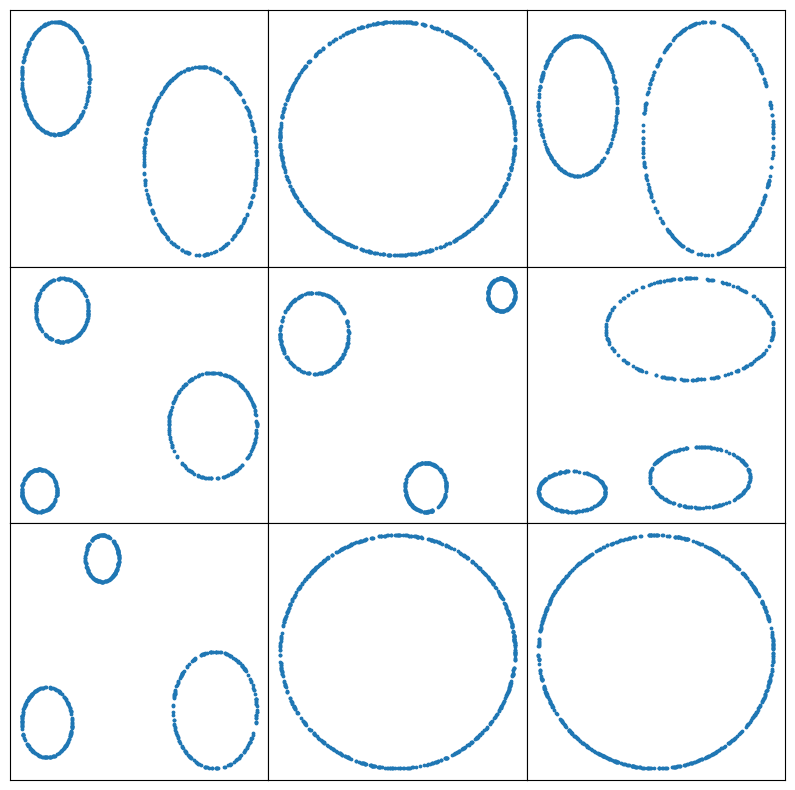

In [9]:
fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(3, 3, width_ratios=[1,1,1], wspace=0.0, hspace=0.0)
for i in range(3):
    for j in range(3):
        ax = plt.subplot(gs[i,j])
        ax.scatter(clean_data_test[3*i+j][:,0], clean_data_test[3*i+j][:,1], s=3)
        plt.xticks([])
        plt.yticks([])
plt.savefig('clean_gudhi_pc.png', bbox_inches='tight')

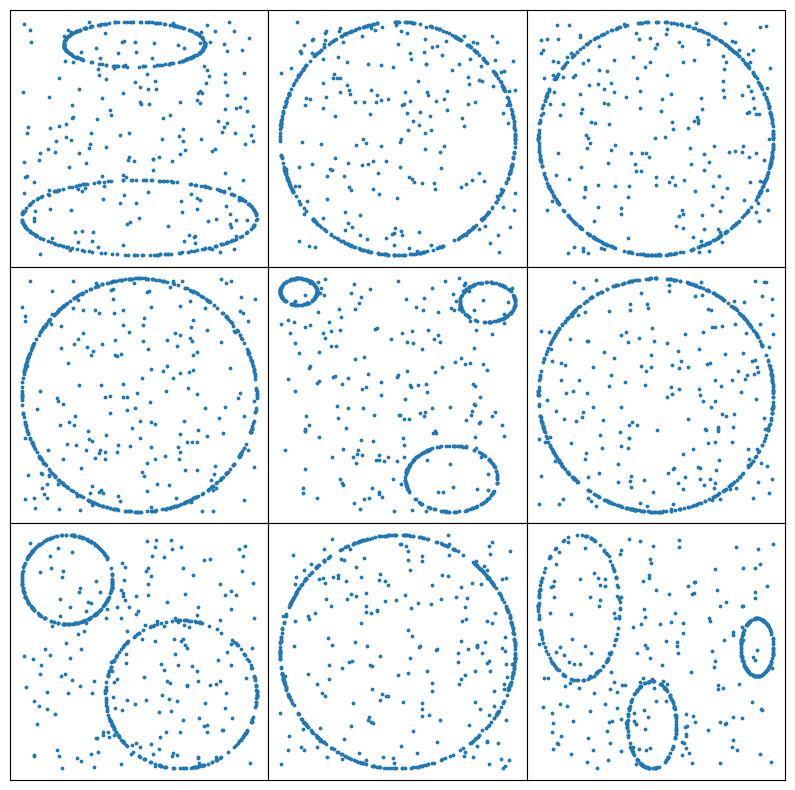

In [10]:
fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(3, 3, width_ratios=[1,1,1], wspace=0.0, hspace=0.0)
for i in range(3):
    for j in range(3):
        ax = plt.subplot(gs[i,j])
        ax.scatter(noisy_data_test[3*i+j][:,0], noisy_data_test[3*i+j][:,1], s=3)
        plt.xticks([])
        plt.yticks([])
plt.savefig('noisy_gudhi_pc.png', bbox_inches='tight')

#### Cleaning Labels
As one can see, they contain 1 to 3 circular shapes. We will use these circle numbers later for checking the accuracy of the topology computed by RipsNet. For now, let's save them as proper labels.

In [11]:
le = LabelEncoder().fit(label_train)
label_classif_train = le.transform(label_train)
clean_label_classif_test  = le.transform(clean_label_test)
noisy_label_classif_test  = le.transform(noisy_label_test)

#### Distance Matrix


In [12]:
def distance_matrix(point_cloud):
    """
    Compute pairwise Euclidean distance matrix for a point cloud.
    Accepts numpy array, list-of-lists, or torch.Tensor of shape (N, d).
    Returns a numpy array of shape (N, N).
    """
    # rely on existing imports: np, torch
    if isinstance(point_cloud, __import__("torch").Tensor):
        point_cloud = point_cloud.cpu().numpy()
    pc = np.asarray(point_cloud, dtype=float)
    if pc.ndim == 1:
        pc = pc.reshape(-1, 1)
    diff = pc[:, None, :] - pc[None, :, :]
    return np.sqrt((diff ** 2).sum(axis=-1))

In [13]:
dm_train = []
for X in tqdm(data_train, desc='Computing DM for training data'):
    dm_train.append(distance_matrix(X))

dm_clean_test = []
for X in tqdm(clean_data_test, desc='Computing DM for clean test data'):
    dm_clean_test.append(distance_matrix(X))

dm_noisy_test = []
for X in tqdm(noisy_data_test, desc='Computing DM for noisy test data'):
    dm_noisy_test.append(distance_matrix(X))

print(f"Shape of first training distance matrix: {dm_train[0].shape}")
print(f"Shape of first clean test distance matrix: {dm_clean_test[0].shape}")
print(f"Shape of first noisy test distance matrix: {dm_noisy_test[0].shape}")

Computing DM for noisy test data: 100%|██████████| 300/300 [00:05<00:00, 50.69it/s]

Shape of first training distance matrix: (600, 600)
Shape of first clean test distance matrix: (600, 600)
Shape of first noisy test distance matrix: (600, 600)


### Topology of point clouds

In order to train RipsNet or other DL models, we need the correct topology on the train  data. So let's compute it with [Gudhi](https://gudhi.inria.fr/python/latest/). The topology of point clouds can be inferred from several filtrations, so we will use a fast and sparse one (in 2D), namely the [Alpha filtration](https://gudhi.inria.fr/python/latest/alpha_complex_user.html). First, we need to get a sense of the maximal filtration value to use, which we will approximate with the largest pairwise distance of the first 30 point clouds.

In [14]:
ds = [pairwise_distances(X).flatten() for X in data_train[:30]]
maxd = np.max(np.concatenate(ds))

#### Persistence diagrams
Now, we can compute the persistence diagrams (in homology dimension 1) of the train, clean test and noisy test point clouds!

In [15]:
PD_train = []
for X in tqdm(data_train):
    st = gd.AlphaComplex(points=X).create_simplex_tree(max_alpha_square=maxd)
    st.persistence()
    dg = st.persistence_intervals_in_dimension(1)
    if len(dg) == 0:
        dg = np.empty([0,2])
    PD_train.append(dg)

100%|██████████| 900/900 [00:15<00:00, 59.83it/s]


In [16]:
clean_PD_test = []
for X in tqdm(clean_data_test):
    st = gd.AlphaComplex(points=X).create_simplex_tree(max_alpha_square=maxd)
    st.persistence()
    dg = st.persistence_intervals_in_dimension(1)
    if len(dg) == 0:
        dg = np.empty([0,2])
    clean_PD_test.append(dg)

100%|██████████| 300/300 [00:04<00:00, 64.18it/s]


In [17]:
noisy_PD_test = []
for X in tqdm(noisy_data_test):
    st = gd.AlphaComplex(points=X).create_simplex_tree(max_alpha_square=maxd)
    st.persistence()
    dg = st.persistence_intervals_in_dimension(1)
    if len(dg) == 0:
        dg = np.empty([0,2])
    noisy_PD_test.append(dg)

100%|██████████| 300/300 [00:03<00:00, 89.28it/s]


#### Persistence Image & Persistence Landscape
RipsNet actually works on vectorizations of persistence diagrams (PDs), so we will try two: the [persistence image](https://jmlr.org/papers/volume18/16-337/16-337.pdf), and the [persistence landscape](https://jmlr.csail.mit.edu/papers/volume16/bubenik15a/bubenik15a.pdf). First, let's filter out any PD point with infinite coordinates.

In [18]:
pds_train      = DiagramSelector(use=True).fit_transform(PD_train)
clean_pds_test = DiagramSelector(use=True).fit_transform(clean_PD_test)
noisy_pds_test = DiagramSelector(use=True).fit_transform(noisy_PD_test)

Fortunately, Gudhi also has code for computing vectorizations!! However, before launching the computations, we have to estimate a few parameters: the image bandwidth (taken as the 20% quantile of the positive birth-persistence-transformed-PD pairwise distances),
and the image and landscape limits (taken as the min and max of birth-persistence-transformed-PD point coordinates).

In [19]:
vpdtr = np.vstack(pds_train)
pers = vpdtr[:,1]-vpdtr[:,0]
bps_pairs = pairwise_distances(np.hstack([vpdtr[:,0:1],vpdtr[:,1:2]-vpdtr[:,0:1]])[:200]).flatten()
ppers = bps_pairs[np.argwhere(bps_pairs > 1e-5).ravel()]
sigma = np.quantile(ppers, .2)
im_bnds = [np.quantile(vpdtr[:,0],0.), np.quantile(vpdtr[:,0],1.), np.quantile(pers,0.), np.quantile(pers,1.)]
sp_bnds = [np.quantile(vpdtr[:,0],0.), np.quantile(vpdtr[:,1],1.)]

We can now compute and normalize the vectorizations (this can help RipsNet training)!

In [20]:
if 'im_bnds' not in locals() or im_bnds is None:
    all_points = np.concatenate(pds_train, axis=0)
    x_min, x_max = np.min(all_points[:, 0]), np.max(all_points[:, 0])
    y_min, y_max = np.min(all_points[:, 1]), np.max(all_points[:, 1])
    im_bnds = [x_min, x_max, y_min, y_max]

PI_params = {
    'bandwidth': sigma,
    'weight': lambda x: 10 * np.tanh(x[1]),
    'resolution': [50, 50],
    'im_range': im_bnds
}

PI = PersistenceImage(**PI_params)
PI.fit(pds_train)

PI_train = PI.transform(pds_train)
clean_PI_test = PI.transform(clean_pds_test)
noisy_PI_test = PI.transform(noisy_pds_test)

MPI = np.max(PI_train)
if MPI == 0 or np.isnan(MPI):
    raise ValueError("MPI (max value) is zero or NaN; check persistence diagrams.")
else:
    PI_train /= MPI
    clean_PI_test /= MPI
    noisy_PI_test /= MPI

PI_train = torch.tensor(PI_train, dtype=torch.float32)
clean_PI_test = torch.tensor(clean_PI_test, dtype=torch.float32)
noisy_PI_test = torch.tensor(noisy_PI_test, dtype=torch.float32)

print(f"PI_train shape: {PI_train.shape}")
print(f"clean_PI_test shape: {clean_PI_test.shape}")
print(f"noisy_PI_test shape: {noisy_PI_test.shape}")
print(f"Max pixel intensity (MPI): {MPI:.5f}")


PI_train shape: torch.Size([900, 2500])
clean_PI_test shape: torch.Size([300, 2500])
noisy_PI_test shape: torch.Size([300, 2500])
Max pixel intensity (MPI): 0.15117


In [21]:

if 'sp_bnds' not in locals() or sp_bnds is None:
    all_points = np.concatenate(pds_train, axis=0)
    x_min, x_max = np.min(all_points[:, 0]), np.max(all_points[:, 1])
    sp_bnds = [x_min, x_max]


PL_params = {
    'num_landscapes': 5,
    'resolution': 300,
    'sample_range': sp_bnds
}

PL = Landscape(**PL_params)
PL.fit(pds_train)

PL_train = PL.transform(pds_train)
clean_PL_test = PL.transform(clean_pds_test)
noisy_PL_test = PL.transform(noisy_pds_test)

MPL = np.max(PL_train)
if MPL == 0 or np.isnan(MPL):
    raise ValueError("MPL (max landscape value) is zero or NaN; check your persistence diagrams.")
else:
    PL_train /= MPL
    clean_PL_test /= MPL
    noisy_PL_test /= MPL

PL_train = torch.tensor(PL_train, dtype=torch.float32)
clean_PL_test = torch.tensor(clean_PL_test, dtype=torch.float32)
noisy_PL_test = torch.tensor(noisy_PL_test, dtype=torch.float32)

print(f"PL_train shape: {PL_train.shape}")
print(f"clean_PL_test shape: {clean_PL_test.shape}")
print(f"noisy_PL_test shape: {noisy_PL_test.shape}")
print(f"Max landscape value (MPL): {MPL:.5f}")


PL_train shape: torch.Size([900, 1500])
clean_PL_test shape: torch.Size([300, 1500])
noisy_PL_test shape: torch.Size([300, 1500])
Max landscape value (MPL): 17.58219


#### Convert Point Clouds to Ragged Tensors

In [22]:
tf_data_train = [torch.tensor(pc, dtype=torch.float32) for pc in data_train]
tf_clean_data_test = [torch.tensor(pc, dtype=torch.float32) for pc in clean_data_test]
tf_noisy_data_test = [torch.tensor(pc, dtype=torch.float32) for pc in noisy_data_test]

## Presentation of Models and Tests


### Models

#### RipsNet (RaggedPersistenceModel)

##### Presentation of RipsNet




**Structure:**
RipsNet, implemented as `RaggedPersistenceModel`, is a neural network designed to process varying-sized inputs (like point clouds) using a DeepSet-like architecture. It consists of:
1.  **Ragged Layers (`DenseRagged`):** These are essentially fully-connected layers applied independently to each point in the input point cloud. They learn per-point features. The `DenseRagged` class handles the variable size of point clouds by applying the same weights to each point and operating on lists of tensors.
2.  **Permutation-Invariant Pooling (`PermopRagged`):** After the ragged layers, a permutation-invariant operation (in this case, summation across all point features) is applied to aggregate the per-point features into a fixed-size global descriptor for the entire point cloud.
3.  **Fully Connected Layers (`fc`):** A series of standard fully-connected layers process the global descriptor to produce the final output, which is a vectorized topological descriptor (either a Persistence Image or a Persistence Landscape).

**Motivation:**
RipsNet was proposed to overcome the computational bottleneck of traditional Topological Data Analysis (TDA) methods, which are often slow when applied to large datasets. The key idea is to *learn* a mapping from raw point cloud data directly to stable topological descriptors (like Persistence Images or Landscapes), bypassing the explicit computation of persistence diagrams. This allows for faster processing of new data points and integrates topological feature extraction into an end-to-end learning framework. Its DeepSet architecture inherently handles the unordered nature of point clouds.

##### Implementation of RipsNet(code)

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Redefining DenseRagged to correctly handle device placement of dynamically created parameters
class DenseRagged(nn.Module):
    def __init__(self, in_features=None, out_features=30, activation='relu', use_bias=True):
        super(DenseRagged, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.use_bias = use_bias
        self.activation = activation

        # Parameters will be initialized on first forward pass.
        self.weight_param = None # Use distinct names for registered parameters
        self.bias_param = None

    def forward(self, inputs):
        outputs = []
        for x in inputs:
            if self.weight_param is None: # Check if parameters have been initialized
                in_features = x.shape[-1]
                # Initialize weight on the same device as input x
                self.weight_param = nn.Parameter(torch.randn(in_features, self.out_features, device=x.device) * 0.01)
                self.register_parameter('weight_param', self.weight_param) # Register the parameter
                if self.use_bias:
                    # Initialize bias on the same device as input x
                    self.bias_param = nn.Parameter(torch.zeros(self.out_features, device=x.device))
                    self.register_parameter('bias_param', self.bias_param) # Register the parameter

            y = torch.matmul(x, self.weight_param) # Use the registered parameter
            if self.use_bias:
                y = y + self.bias_param # Use the registered parameter
            if self.activation == 'relu':
                y = F.relu(y)
            elif self.activation == 'sigmoid':
                y = torch.sigmoid(y)
            elif self.activation == 'tanh':
                y = torch.tanh(y)
            outputs.append(y)
        return outputs

# Redefining PermopRagged (no changes needed, but must be in scope if RaggedPersistenceModel is redefined)
class PermopRagged(nn.Module):
    def forward(self, inputs):
        return torch.stack([torch.sum(x, dim=0) for x in inputs])

# Redefining RaggedPersistenceModel to use the corrected DenseRagged
class RaggedPersistenceModel(nn.Module):
    def __init__(self, output_dim):
        super(RaggedPersistenceModel, self).__init__()
        self.ragged_layers = nn.ModuleList([
            DenseRagged(out_features=30, activation='relu'),
            DenseRagged(out_features=20, activation='relu'),
            DenseRagged(out_features=10, activation='relu')
        ])
        self.perm = PermopRagged()

        self.fc = nn.Sequential(
            nn.Linear(10, 50),
            nn.ReLU(),
            nn.Linear(50, 100),
            nn.ReLU(),
            nn.Linear(100, 200),
            nn.ReLU(),
            nn.Linear(200, output_dim),
            nn.Sigmoid()
        )

    def forward(self, inputs):
        x = inputs
        for layer in self.ragged_layers:
            x = layer(x)
        x = self.perm(x)
        x = self.fc(x)
        return x

#### DistanceMatrixRaggedModel

##### Presentation of DistanceMatrixRaggedModel

**Structure:**
The `DistanceMatrixRaggedModel` is an adaptation designed to predict topological descriptors directly from pairwise distance matrices of point clouds. It incorporates optional Graph Neural Network (GNN) layers to enrich feature learning:
1.  **Per-Row MLP (`_phi_mlp`):** Each row of the input distance matrix is treated as a feature vector for a point. A multi-layer perceptron (MLP) transforms these per-row feature vectors into a higher-dimensional embedding for each point.
2.  **GNN-like Aggregation (Optional):** If `gnn_enabled` is true, the model constructs an adjacency matrix from the distance matrix (representing connections between points) and applies graph convolutional layers. These layers facilitate message passing and aggregation of features between neighboring points, allowing the model to learn context-aware features.
3.  **Global Pooling:** After the per-point feature extraction (and optional GNN layers), a global pooling operation (summation) aggregates the point-wise features into a single, fixed-size vector representing the entire point cloud.
4.  **Fully Connected Layers (`rho`):** A final set of fully-connected layers processes this global descriptor to produce the target topological representation.

**Motivation:**
This model was proposed to leverage the inherent permutation invariance and isometry invariance of distance matrices. By taking the distance matrix as input, the model is inherently robust to rigid transformations (rotations and translations) of the point cloud. The optional GNN layers aim to capture local and global geometric relationships within the point cloud more effectively by explicitly modeling the graph structure derived from distances, potentially leading to richer and more robust topological feature learning, especially for noisy data.



##### Implementation of DistanceMatrixRaggedModel

In [24]:
import torch
import torch.nn as nn
from typing import List

class DistanceMatrixRaggedModel(nn.Module):
    def __init__(self, output_dim, num_points=None, phi_dim=128, rho_hidden=(256,128)):
        """
        output_dim: final descriptor size (e.g., PI_train.shape[1])
        num_points: expected number of points (row length). If None, model infers size at first forward.
        phi_dim: per-row embedding size
        rho_hidden: sizes of hidden layers for global map
        """
        super().__init__()
        self.num_points = num_points
        inp = num_points if num_points is not None else 0
        self._phi_layers = None
        self.phi_dim = phi_dim
        self._build_phi(inp)
        layers = []
        prev = phi_dim
        for h in rho_hidden:
            layers.append(nn.Linear(prev, h))
            layers.append(nn.ReLU())
            prev = h
        layers.append(nn.Linear(prev, output_dim))
        self.rho = nn.Sequential(*layers)

    def _build_phi(self, inp):
        if inp <= 0:
            self._phi_layers = None
            return
        hidden = max(64, self.phi_dim)
        self._phi_layers = nn.Sequential(
            nn.Linear(inp, hidden),
            nn.ReLU(),
            nn.Linear(hidden, self.phi_dim),
            nn.ReLU()
        )

    def forward(self, batch: List[torch.Tensor]):
        """
        batch: list of (Ni x Ni) distance matrices (torch.Tensor)
        returns: (B, output_dim)
        """
        if len(batch) == 0:
            return torch.empty(0, self.rho[-1].out_features, device=next(self.parameters()).device)

        sizes = [m.shape[0] for m in batch]
        max_n = max(sizes)
        device = next(self.parameters()).device

        if self._phi_layers is None or (self.num_points and self.num_points != max_n):
            self._build_phi(max_n)
            self.num_points = max_n
            self._phi_layers = self._phi_layers.to(device)

        B = len(batch)
        mats = torch.zeros((B, max_n, max_n), dtype=torch.float32, device=device)
        row_mask = torch.zeros((B, max_n), dtype=torch.bool, device=device)
        for i, m in enumerate(batch):
            n = m.shape[0]
            mats[i, :n, :n] = m.to(device).float()
            row_mask[i, :n] = 1

        rows = mats.reshape(B * max_n, max_n)
        phi_out = self._phi_layers(rows)
        phi_out = phi_out.reshape(B, max_n, -1)

        lengths = row_mask.sum(dim=1).clamp(min=1).unsqueeze(-1).float()
        summed = (phi_out * row_mask.unsqueeze(-1).float()).sum(dim=1)
        aggregated = summed / lengths

        out = self.rho(aggregated)
        return out


#### PointNet

##### Presentation of PointNet

**Structure:**
The `PointNet` model implemented here is a simplified version of the seminal PointNet architecture, designed for processing raw point clouds while respecting their unordered nature. It comprises:
1.  **Shared MLP (`phi_layers`):** An MLP is applied independently to each point's coordinates (in this case, 2D coordinates `(x, y)`). This MLP transforms each point into a higher-dimensional feature vector. The weights of this MLP are shared across all points, ensuring permutation invariance for this step.
2.  **Max-Pooling (Permutation-Invariant Aggregation):** After the shared MLP, a global max-pooling operation is applied across all per-point features. This operation selects the maximum value for each feature dimension across all points, resulting in a single, fixed-size global feature vector for the entire point cloud. Max-pooling is inherently permutation-invariant.
3.  **Global MLP (`rho_layers`):** A series of fully-connected layers (rho function) process the global feature vector obtained from max-pooling to produce the final output, which is the predicted topological descriptor (Persistence Image or Persistence Landscape).

**Motivation:**
PointNet was proposed to directly consume unordered point clouds, without the need for conversion to intermediate representations like meshes or voxel grids. Its core innovation lies in its ability to achieve permutation invariance through shared MLP weights and symmetric aggregation functions (like max-pooling). This allows the network to learn rich features from each point individually and then combine them in a way that is robust to the arbitrary ordering of points, making it suitable for tasks like shape classification, part segmentation, and, in this context, learning topological descriptors.


##### Implementation of PointNet

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from typing import List

class PointNet(nn.Module):
    def __init__(self, output_dim, phi_dims=[64, 128, 256], rho_dims=[256, 128]):
        super().__init__()

        # Phi function (shared MLP) - maps each point to a feature vector
        phi_layers = []
        in_features = 2 # 2D points
        for dim in phi_dims:
            phi_layers.append(nn.Linear(in_features, dim))
            phi_layers.append(nn.ReLU())
            in_features = dim
        self.phi_layers = nn.Sequential(*phi_layers)

        # Rho function (global MLP) - processes aggregated features
        rho_layers = []
        in_features = phi_dims[-1] # Input to rho is the max-pooled feature from phi
        for dim in rho_dims:
            rho_layers.append(nn.Linear(in_features, dim))
            rho_layers.append(nn.ReLU())
            in_features = dim
        rho_layers.append(nn.Linear(in_features, output_dim))
        # No activation on the final layer for regression tasks
        self.rho_layers = nn.Sequential(*rho_layers)

    def forward(self, batch: List[torch.Tensor]):
        if len(batch) == 0:
            # Return an empty tensor with the correct output dimension if batch is empty
            return torch.empty(0, self.rho_layers[-1].out_features, device=next(self.parameters()).device)

        # Pad point clouds to the maximum length in the batch
        # `pad_sequence` expects a list of tensors of shape (L, *) where L is sequence length
        padded_batch = pad_sequence(batch, batch_first=True, padding_value=0.0)
        # original_lengths = [len(pc) for pc in batch]

        # Create a mask for valid points
        # Shape: (batch_size, max_num_points)
        mask = torch.zeros(padded_batch.shape[0], padded_batch.shape[1], dtype=torch.bool, device=padded_batch.device)
        for i, pc in enumerate(batch):
            mask[i, :len(pc)] = True

        # Apply shared MLP (phi function) to all points
        # Reshape to (total_num_points_in_batch, input_dim) for MLP, then reshape back
        # phi_out shape: (batch_size, max_num_points, phi_dims[-1])
        phi_out = self.phi_layers(padded_batch.view(-1, padded_batch.shape[-1]))
        phi_out = phi_out.view(padded_batch.shape[0], padded_batch.shape[1], -1)

        # Apply mask before max-pooling
        # Set features of padded points to a very small negative value
        # so they don't affect the max operation (especially with ReLU later in rho)
        min_val = torch.finfo(phi_out.dtype).min
        masked_phi_out = phi_out.masked_fill(~mask.unsqueeze(-1), min_val)

        # Permutation-invariant aggregation (max-pooling over points)
        # aggregated_features shape: (batch_size, phi_dims[-1])
        aggregated_features, _ = torch.max(masked_phi_out, dim=1)

        # Apply global MLP (rho function)
        # output shape: (batch_size, output_dim)
        output = self.rho_layers(aggregated_features)

        return output

print("PointNet class defined.")

PointNet class defined.


#### LinearEnsemble

#### NormModel

#### DistanceMatrixConvNet

## Training of Models

### RipsNet (still need cleanup)

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

output_dim = PI_train.shape[1]
model_PI = RaggedPersistenceModel(output_dim=output_dim)

optimizer = Adamax(model_PI.parameters(), lr=5e-4)
criterion = nn.MSELoss()

# Training RipsNet to predict Persistence Images (original training loop)
model = model_PI
criterion = nn.MSELoss()
optimizer = torch.optim.Adamax(model_PI.parameters(), lr=5e-4)
train_inputs = [torch.tensor(x, dtype=torch.float32).to(device) for x in tf_data_train]
train_targets = torch.tensor(PI_train, dtype=torch.float32).to(device)
val_inputs = [torch.tensor(x, dtype=torch.float32).to(device) for x in tf_clean_data_test]
val_targets = torch.tensor(clean_PI_test, dtype=torch.float32).to(device)

# Re-instantiate model_PI with the new class definition
output_dim = PI_train.shape[1]
model_PI = RaggedPersistenceModel(output_dim=output_dim)

# Re-prepare inputs to avoid UserWarnings and ensure they are on the correct device.
# Assuming tf_data_train, PI_train, tf_clean_data_test, clean_PI_test are correctly defined
# and `device` is set up.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_inputs = [pc.to(device) for pc in tf_data_train]
train_targets = PI_train.to(device)
val_inputs = [pc.to(device) for pc in tf_clean_data_test]
val_targets = clean_PI_test.to(device)

# Redefine optimizer here to use the new model_PI parameters.
optimizer = Adamax(model_PI.parameters(), lr=5e-4)
criterion = nn.MSELoss() # Criterion remains the same

# Ensure num_epochs is defined
try:
    num_epochs
except NameError:
    num_epochs = 10000

model_PI, history_PI, best_model_state = train_model(
    model_PI, optimizer, criterion,
    train_inputs, train_targets,
    val_inputs, val_targets,
    epochs=num_epochs, batch_size=32
)

best_val_loss = min(history_PI['val_loss']) if history_PI.get('val_loss') else float('inf')
print(f"Training complete. Best val_loss = {best_val_loss:.6f}")


/tmp/ipython-input-2171539897.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_inputs = [torch.tensor(x, dtype=torch.float32).to(device) for x in tf_data_train]
/tmp/ipython-input-2171539897.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_targets = torch.tensor(PI_train, dtype=torch.float32).to(device)
/tmp/ipython-input-2171539897.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_inputs = [torch.tensor(x, dtype=torch.float32).to(device) for x in tf_clean_data_test]
/tmp/ipython-input-2171539897.py:16: UserWarn

Epoch 1/10000, Train Loss: 0.198740, Val Loss: 0.175329
Epoch 2/10000, Train Loss: 0.136977, Val Loss: 0.082510
Epoch 3/10000, Train Loss: 0.039559, Val Loss: 0.011771
Epoch 4/10000, Train Loss: 0.007638, Val Loss: 0.005392
Epoch 5/10000, Train Loss: 0.004798, Val Loss: 0.004324
Epoch 6/10000, Train Loss: 0.004137, Val Loss: 0.003916
Epoch 7/10000, Train Loss: 0.003834, Val Loss: 0.003700
Epoch 8/10000, Train Loss: 0.003662, Val Loss: 0.003576
Epoch 9/10000, Train Loss: 0.003564, Val Loss: 0.003497
Epoch 10/10000, Train Loss: 0.003503, Val Loss: 0.003445
Epoch 11/10000, Train Loss: 0.003457, Val Loss: 0.003411
Epoch 12/10000, Train Loss: 0.003433, Val Loss: 0.003385
Epoch 13/10000, Train Loss: 0.003409, Val Loss: 0.003369
Epoch 14/10000, Train Loss: 0.003387, Val Loss: 0.003354
Epoch 15/10000, Train Loss: 0.003376, Val Loss: 0.003346
Epoch 16/10000, Train Loss: 0.003372, Val Loss: 0.003340
Epoch 17/10000, Train Loss: 0.003362, Val Loss: 0.003330
Epoch 18/10000, Train Loss: 0.003356, Va

In [27]:
model_PI.eval()

with torch.no_grad():
    # ensure inputs have the same dtype as the model parameters (float32)
    train_inputs = [torch.tensor(x, dtype=torch.float32).to(device) for x in tf_data_train]
    clean_inputs = [torch.tensor(x, dtype=torch.float32).to(device) for x in tf_clean_data_test]
    noisy_inputs = [torch.tensor(x, dtype=torch.float32).to(device) for x in tf_noisy_data_test]

    train_PI_prediction = model_PI(train_inputs).cpu().numpy()
    clean_PI_prediction = model_PI(clean_inputs).cpu().numpy()
    noisy_PI_prediction = model_PI(noisy_inputs).cpu().numpy()

print("Predictions computed:")
print(f"train_PI_prediction shape: {train_PI_prediction.shape}")
print(f"clean_PI_prediction shape: {clean_PI_prediction.shape}")
print(f"noisy_PI_prediction shape: {noisy_PI_prediction.shape}")


/tmp/ipython-input-2216463292.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_inputs = [torch.tensor(x, dtype=torch.float32).to(device) for x in tf_data_train]
/tmp/ipython-input-2216463292.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  clean_inputs = [torch.tensor(x, dtype=torch.float32).to(device) for x in tf_clean_data_test]
/tmp/ipython-input-2216463292.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  noisy_inputs = [torch.tensor(x, dtype=torch.float32).to(device) for x in tf_noisy_data_test]


Predictions computed:
train_PI_prediction shape: (900, 2500)
clean_PI_prediction shape: (300, 2500)
noisy_PI_prediction shape: (300, 2500)


In [ ]:
output_dim = PL_train.shape[1]
model_PL = RaggedPersistenceModel(output_dim=output_dim)

optimizer = Adamax(model_PL.parameters(), lr=5e-4)
criterion = nn.MSELoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_PL = model_PL.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adamax(model_PL.parameters(), lr=5e-4)

patience = 20
best_val_loss = float('inf')
patience_counter = 0
num_epochs = 10000

# prepare data once (move to device)
train_inputs = [x.to(device).float() if isinstance(x, torch.Tensor) else torch.tensor(x, dtype=torch.float32, device=device) for x in tf_data_train]
train_targets = torch.tensor(PL_train, dtype=torch.float32, device=device)

val_inputs = [x.to(device).float() if isinstance(x, torch.Tensor) else torch.tensor(x, dtype=torch.float32, device=device) for x in tf_clean_data_test]
val_targets = torch.tensor(clean_PL_test, dtype=torch.float32, device=device)

history = {'train_loss': [], 'val_loss': []}
best_model_state = {k: v.cpu() for k, v in model_PL.state_dict().items()}

for epoch in range(num_epochs):
    model_PL.train()
    optimizer.zero_grad()

    outputs = model_PL(train_inputs)
    if isinstance(outputs, (list, tuple)):
        outputs = outputs[0]
    if outputs is None:
        raise RuntimeError("model_PL returned None")
    if not isinstance(outputs, torch.Tensor):
        outputs = torch.tensor(outputs, dtype=train_targets.dtype, device=train_targets.device)
    else:
        outputs = outputs.to(train_targets.device).type(train_targets.dtype)

    loss = criterion(outputs, train_targets)
    loss.backward()
    optimizer.step()

    model_PL.eval()
    with torch.no_grad():
        val_outputs = model_PL(val_inputs)
        if isinstance(val_outputs, (list, tuple)):
            val_outputs = val_outputs[0]
        val_outputs = val_outputs.to(val_targets.device).type(val_targets.dtype)
        val_loss = criterion(val_outputs, val_targets)

    history['train_loss'].append(loss.item())
    history['val_loss'].append(val_loss.item())

    if val_loss.item() < best_val_loss - 1e-5:
        best_val_loss = val_loss.item()
        patience_counter = 0
        # save on CPU to avoid GPU memory hold
        best_model_state = {k: v.cpu().clone() for k, v in model_PL.state_dict().items()}
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

    if (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {loss.item():.6f}, Val loss: {val_loss.item():.6f}")

# load best weights back to device
model_PL.load_state_dict({k: v.to(device) for k, v in best_model_state.items()})
print(f"Training complete. Best val_loss = {best_val_loss:.6f}")


/tmp/ipython-input-1017348827.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_targets = torch.tensor(PL_train, dtype=torch.float32, device=device)
/tmp/ipython-input-1017348827.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_targets = torch.tensor(clean_PL_test, dtype=torch.float32, device=device)


Epoch 50/10000 - Train loss: 0.139807, Val loss: 0.136203
Epoch 100/10000 - Train loss: 0.015297, Val loss: 0.014951
Epoch 150/10000 - Train loss: 0.010807, Val loss: 0.010762
Epoch 200/10000 - Train loss: 0.010124, Val loss: 0.010097
Epoch 250/10000 - Train loss: 0.009866, Val loss: 0.009845
Epoch 300/10000 - Train loss: 0.009713, Val loss: 0.009695
Epoch 350/10000 - Train loss: 0.009508, Val loss: 0.009492
Epoch 400/10000 - Train loss: 0.009140, Val loss: 0.009127
Epoch 450/10000 - Train loss: 0.008480, Val loss: 0.008475
Epoch 500/10000 - Train loss: 0.007355, Val loss: 0.007364
Epoch 550/10000 - Train loss: 0.005799, Val loss: 0.005839
Epoch 600/10000 - Train loss: 0.004265, Val loss: 0.004350
Epoch 650/10000 - Train loss: 0.003344, Val loss: 0.003436
Epoch 700/10000 - Train loss: 0.002824, Val loss: 0.002881
Epoch 750/10000 - Train loss: 0.002416, Val loss: 0.002427
Epoch 800/10000 - Train loss: 0.002162, Val loss: 0.002126
Epoch 850/10000 - Train loss: 0.001981, Val loss: 0.00190

In [ ]:
model_PL.eval()

with torch.no_grad():
    train_inputs = [torch.tensor(x, dtype=torch.float32).to(device) for x in tf_data_train]
    clean_inputs = [torch.tensor(x, dtype=torch.float32).to(device) for x in tf_clean_data_test]
    noisy_inputs = [torch.tensor(x, dtype=torch.float32).to(device) for x in tf_noisy_data_test]

    train_PL_prediction = model_PL(train_inputs).cpu().numpy()
    clean_PL_prediction = model_PL(clean_inputs).cpu().numpy()
    noisy_PL_prediction = model_PL(noisy_inputs).cpu().numpy()

print("Predictions computed:")
print(f"train_PI_prediction shape: {train_PL_prediction.shape}")
print(f"clean_PI_prediction shape: {clean_PL_prediction.shape}")
print(f"noisy_PI_prediction shape: {noisy_PL_prediction.shape}")

### DistanceMatrixRaggedModel

In [ ]:
output_dim_pi = PI_train.shape[1]
model_dm_pi = DistanceMatrixRaggedModel(output_dim=output_dim_pi)

print(f"Initialized DistanceMatrixRaggedModel for PI with output_dim: {output_dim_pi}")

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_dm_pi.to(device)
criterion = nn.MSELoss()
optimizer = Adamax(model_dm_pi.parameters(), lr=5e-4)

# Ensure num_epochs is defined
try:
    num_epochs
except NameError:
    num_epochs = 10000

model_dm_pi, history_dm_pi, best_model_state_dm_pi = train_model(
    model_dm_pi, optimizer, criterion,
    dm_train, PI_train,
    dm_clean_test, clean_PI_test,
    epochs=num_epochs, batch_size=32
)

best_val_loss_dm_pi = min(history_dm_pi['val_loss']) if history_dm_pi.get('val_loss') else float('inf')
print(f"Training DistanceMatrixRaggedModel for PI complete. Best val_loss = {best_val_loss_dm_pi:.6f}")

In [ ]:
model_dm_pi.eval()

with torch.no_grad():
    dm_train_tensor = [torch.tensor(dm, dtype=torch.float32).to(device) for dm in dm_train]
    dm_clean_test_tensor = [torch.tensor(dm, dtype=torch.float32).to(device) for dm in dm_clean_test]
    dm_noisy_test_tensor = [torch.tensor(dm, dtype=torch.float32).to(device) for dm in dm_noisy_test]

    dm_train_PI_prediction = model_dm_pi(dm_train_tensor).cpu().numpy()
    dm_clean_PI_prediction = model_dm_pi(dm_clean_test_tensor).cpu().numpy()
    dm_noisy_PI_prediction = model_dm_pi(dm_noisy_test_tensor).cpu().numpy()

print("Predictions computed for DistanceMatrixRaggedModel for PI:")
print(f"dm_train_PI_prediction shape: {dm_train_PI_prediction.shape}")
print(f"dm_clean_PI_prediction shape: {dm_clean_PI_prediction.shape}")
print(f"dm_noisy_PI_prediction shape: {dm_noisy_PI_prediction.shape}")


In [ ]:
output_dim_pl = PL_train.shape[1]
model_dm_pl = DistanceMatrixRaggedModel(output_dim=output_dim_pl)

print(f"Initialized DistanceMatrixRaggedModel for PL with output_dim: {output_dim_pl}")

model_dm_pl.to(device)
criterion_pl = nn.MSELoss()
optimizer_pl = Adamax(model_dm_pl.parameters(), lr=5e-4)

# Ensure num_epochs is defined
try:
    num_epochs
except NameError:
    num_epochs = 10000

model_dm_pl, history_dm_pl, best_model_state_dm_pl = train_model(
    model_dm_pl, optimizer_pl, criterion_pl,
    dm_train, PL_train,
    dm_clean_test, clean_PL_test,
    epochs=num_epochs, batch_size=32
)

best_val_loss_dm_pl = min(history_dm_pl['val_loss']) if history_dm_pl.get('val_loss') else float('inf')
print(f"Training DistanceMatrixRaggedModel for PL complete. Best val_loss = {best_val_loss_dm_pl:.6f}")

In [ ]:
model_dm_pl.eval()

with torch.no_grad():
    # Ensure inputs are on the correct device and dtype for prediction
    dm_train_tensor_pl = [torch.tensor(dm, dtype=torch.float32).to(device) for dm in dm_train]
    dm_clean_test_tensor_pl = [torch.tensor(dm, dtype=torch.float32).to(device) for dm in dm_clean_test]
    dm_noisy_test_tensor_pl = [torch.tensor(dm, dtype=torch.float32).to(device) for dm in dm_noisy_test]

    dm_train_PL_prediction = model_dm_pl(dm_train_tensor_pl).cpu().numpy()
    dm_clean_PL_prediction = model_dm_pl(dm_clean_test_tensor_pl).cpu().numpy()
    dm_noisy_PL_prediction = model_dm_pl(dm_noisy_test_tensor_pl).cpu().numpy()

print("Predictions computed for DistanceMatrixRaggedModel for PL:")
print(f"dm_train_PL_prediction shape: {dm_train_PL_prediction.shape}")
print(f"dm_clean_PL_prediction shape: {dm_clean_PL_prediction.shape}")
print(f"dm_noisy_PL_prediction shape: {dm_noisy_PL_prediction.shape}")

### PointNet

In [ ]:
output_dim_pi_pn = PI_train.shape[1]
model_PN_PI = PointNet(output_dim=output_dim_pi_pn)

print(f"Initialized PointNet for PI with output_dim: {output_dim_pi_pn}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_PN_PI.to(device)
criterion_pn = nn.MSELoss()
optimizer_pn = Adamax(model_PN_PI.parameters(), lr=5e-4)

# Ensure num_epochs is defined
try:
    num_epochs
except NameError:
    num_epochs = 10000

model_PN_PI, history_PN_PI, best_model_state_pn_pi = train_model(
    model_PN_PI, optimizer_pn, criterion_pn,
    tf_data_train, PI_train,
    tf_clean_data_test, clean_PI_test,
    epochs=num_epochs, batch_size=32
)

best_val_loss_pn_pi = min(history_PN_PI['val_loss']) if history_PN_PI.get('val_loss') else float('inf')
print(f"Training PointNet for PI complete. Best val_loss = {best_val_loss_pn_pi:.6f}")

In [ ]:
model_PN_PI.eval()

with torch.no_grad():
    # Ensure inputs are on the correct device and dtype
    tf_data_train_tensor = [torch.tensor(pc, dtype=torch.float32).to(device) for pc in tf_data_train]
    tf_clean_data_test_tensor = [torch.tensor(pc, dtype=torch.float32).to(device) for pc in tf_clean_data_test]
    tf_noisy_data_test_tensor = [torch.tensor(pc, dtype=torch.float32).to(device) for pc in tf_noisy_data_test]

    pn_train_PI_prediction = model_PN_PI(tf_data_train_tensor).cpu().numpy()
    pn_clean_PI_prediction = model_PN_PI(tf_clean_data_test_tensor).cpu().numpy()
    pn_noisy_PI_prediction = model_PN_PI(tf_noisy_data_test_tensor).cpu().numpy()

print("Predictions computed for PointNet for PI:")
print(f"pn_train_PI_prediction shape: {pn_train_PI_prediction.shape}")
print(f"pn_clean_PI_prediction shape: {pn_clean_PI_prediction.shape}")
print(f"pn_noisy_PI_prediction shape: {pn_noisy_PI_prediction.shape}")


In [ ]:
output_dim_pl_pn = PL_train.shape[1]
model_PN_PL = PointNet(output_dim=output_dim_pl_pn)

print(f"Initialized PointNet for PL with output_dim: {output_dim_pl_pn}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_PN_PL.to(device)
criterion_pn_pl = nn.MSELoss()
optimizer_pn_pl = Adamax(model_PN_PL.parameters(), lr=5e-4)

# Ensure num_epochs is defined
try:
    num_epochs
except NameError:
    num_epochs = 10000

model_PN_PL, history_PN_PL, best_model_state_pn_pl = train_model(
    model_PN_PL, optimizer_pn_pl, criterion_pn_pl,
    tf_data_train, PL_train,
    tf_clean_data_test, clean_PL_test,
    epochs=num_epochs, batch_size=32
)

best_val_loss_pn_pl = min(history_PN_PL['val_loss']) if history_PN_PL.get('val_loss') else float('inf')
print(f"Training PointNet for PL complete. Best val_loss = {best_val_loss_pn_pl:.6f}")

model_PN_PL.eval()

with torch.no_grad():
    # Ensure inputs are on the correct device and dtype
    tf_data_train_on_device = [pc.to(device) for pc in tf_data_train]
    tf_clean_data_test_on_device = [pc.to(device) for pc in tf_clean_data_test]
    tf_noisy_data_test_on_device = [pc.to(device) for pc in tf_noisy_data_test]

    pn_train_PL_prediction = model_PN_PL(tf_data_train_on_device).cpu().numpy()
    pn_clean_PL_prediction = model_PN_PL(tf_clean_data_test_on_device).cpu().numpy()
    pn_noisy_PL_prediction = model_PN_PL(tf_noisy_data_test_on_device).cpu().numpy()

print("Predictions computed for PointNet for PL:")
print(f"pn_train_PL_prediction shape: {pn_train_PL_prediction.shape}")
print(f"pn_clean_PL_prediction shape: {pn_clean_PL_prediction.shape}")
print(f"pn_noisy_PL_prediction shape: {pn_noisy_PL_prediction.shape}")

### Linear Ensemble

### NormModel

### DistanceMatrixConvNet

## Test results



### Gudhi

In [ ]:
model_classif_gudhi = XGBClassifier(eval_metric='logloss', use_label_encoder=False)
model_classif_gudhi.fit(PI_train, label_classif_train)
clean_test_acc_gudhi = model_classif_gudhi.score(clean_PI_test, clean_label_classif_test)
noisy_test_acc_gudhi = model_classif_gudhi.score(noisy_PI_test, noisy_label_classif_test)
print("Accuracy on clean test set = " + str(clean_test_acc_gudhi))
print("Accuracy on noisy test set = " + str(noisy_test_acc_gudhi))

In [ ]:
model_classif_gudhi = XGBClassifier(eval_metric='logloss', use_label_encoder=False)
model_classif_gudhi.fit(PL_train, label_classif_train)
clean_test_acc_gudhi = model_classif_gudhi.score(clean_PL_test,  clean_label_classif_test)
noisy_test_acc_gudhi = model_classif_gudhi.score(noisy_PL_test,  noisy_label_classif_test)
print("Accuracy on clean test set = " + str(clean_test_acc_RN))
print("Accuracy on noisy test set = " + str(noisy_test_acc_RN))

### RipsNet (PI/PL)

In [ ]:
fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(3, 3, wspace=0.0, hspace=0.0)

for i in range(3):
    for j in range(3):
        idx = 3 * i + j
        ax = plt.subplot(gs[i, j])

        try:
            data = to_numpy(tf_noisy_data_test[idx])
            if data.shape[1] != 2:
                print(f"Skipping idx={idx}, unexpected shape: {data.shape}")
                continue
            ax.scatter(data[:, 0], data[:, 1], s=3)
        except Exception as e:
            print(f"Error at idx={idx} in noisy point cloud: {e}")
            continue

        ax.set_xticks([])
        ax.set_yticks([])

plt.savefig("noisy_gudhi_pc.png", bbox_inches="tight")
print("Saved noisy_gudhi_pc.png")

fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(3, 3, wspace=0.0, hspace=0.0)

for i in range(3):
    for j in range(3):
        idx = 3 * i + j
        ax = plt.subplot(gs[i, j])

        arr = np.array(noisy_PI_test[idx])
        if arr.size != 50*50:
            print(f"Skipping idx={idx}, unexpected size: {arr.size}")
            continue

        im = np.flip(arr.reshape(50, 50), 0)  # vertical flip
        ax.imshow(im, cmap="jet")
        ax.set_xticks([])
        ax.set_yticks([])

plt.savefig("noisy_gudhi_pi.png", bbox_inches="tight")
print("Saved noisy_gudhi_pi.png")

fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(3, 3, wspace=0.0, hspace=0.0)

for i in range(3):
    for j in range(3):
        idx = 3 * i + j
        ax = plt.subplot(gs[i, j])

        arr = np.array(noisy_PI_prediction[idx])
        if arr.size != 50*50:
            print(f"Skipping idx={idx}, unexpected size: {arr.size}")
            continue

        pred = np.flip(arr.reshape(50, 50), 0)
        ax.imshow(pred, cmap="jet")
        ax.set_xticks([])
        ax.set_yticks([])

plt.savefig("noisy_ripsnet_pi.png", bbox_inches="tight")
print("Saved noisy_ripsnet_pi.png")


In [ ]:
label_classif_train_aug = le.transform(label_train)

model_classif_RN = XGBClassifier(eval_metric='logloss', use_label_encoder=False)
model_classif_RN.fit(train_PI_prediction, label_classif_train_aug)
clean_test_acc_RN = model_classif_RN.score(clean_PI_prediction, clean_label_classif_test)
noisy_test_acc_RN = model_classif_RN.score(noisy_PI_prediction, noisy_label_classif_test)
print("Accuracy on clean test set = " + str(clean_test_acc_RN))
print("Accuracy on noisy test set = " + str(noisy_test_acc_RN))


In [ ]:


fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(3, 3, wspace=0.0, hspace=0.0)

for i in range(3):
    for j in range(3):
        idx = 3 * i + j
        ax = plt.subplot(gs[i, j])

        try:
            data = to_numpy(tf_clean_data_test[idx])
            if data.shape[1] != 2:
                print(f"Skipping idx={idx}, unexpected shape: {data.shape}")
                continue
            ax.scatter(data[:, 0], data[:, 1], s=3)
        except Exception as e:
            print(f"Error at idx={idx} in point cloud: {e}")
            continue

        ax.set_xticks([])
        ax.set_yticks([])

plt.savefig('clean_gudhi_pc.png', bbox_inches='tight')
print("Saved clean_gudhi_pc.png")

fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(3, 3, wspace=0.0, hspace=0.0)

for i in range(3):
    for j in range(3):
        idx = 3 * i + j
        ax = plt.subplot(gs[i, j])

        arr = np.array(clean_PL_test[idx])
        if arr.size != 50*50:
            print(f"Skipping idx={idx}, unexpected size: {arr.size}")
            continue

        im = np.flip(arr.reshape(50, 50), 0)  # vertical flip
        ax.imshow(im, cmap='jet')
        ax.set_xticks([])
        ax.set_yticks([])

plt.savefig('clean_gudhi_pl.png', bbox_inches='tight')
print("Saved clean_gudhi_pl.png")

fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(3, 3, wspace=0.0, hspace=0.0)

for i in range(3):
    for j in range(3):
        idx = 3 * i + j
        ax = plt.subplot(gs[i, j])

        arr = np.array(clean_PL_prediction[idx])
        if arr.size != 50*50:
            print(f"Skipping idx={idx}, unexpected size: {arr.size}")
            continue

        pred = np.flip(arr.reshape(50, 50), 0)
        ax.imshow(pred, cmap='jet')
        ax.set_xticks([])
        ax.set_yticks([])

plt.savefig('clean_ripsnet_pl.png', bbox_inches='tight')
print("Saved clean_ripsnet_pl.png")


In [ ]:
model_classif_RN = XGBClassifier(eval_metric='logloss', use_label_encoder=False)
model_classif_RN.fit(train_PL_prediction, label_classif_train)
clean_test_acc_RN = model_classif_RN.score(clean_PL_prediction, clean_label_classif_test)
noisy_test_acc_RN = model_classif_RN.score(noisy_PL_prediction, noisy_label_classif_test)
print("Accuracy on clean test set = " + str(clean_test_acc_RN))
print("Accuracy on noisy test set = " + str(noisy_test_acc_RN))

### DistanceMatrixRagged

In [ ]:
# Train an XGBoost classifier on the predictions
model_classif_dm_pi = XGBClassifier(eval_metric='logloss', use_label_encoder=False)
model_classif_dm_pi.fit(dm_train_PI_prediction, label_classif_train)

# Evaluate accuracy on clean test set
clean_test_acc_dm_pi = model_classif_dm_pi.score(dm_clean_PI_prediction, clean_label_classif_test)
print(f"Accuracy on clean test set : {clean_test_acc_dm_pi}")

# Evaluate accuracy on noisy test set
noisy_test_acc_dm_pi = model_classif_dm_pi.score(dm_noisy_PI_prediction, noisy_label_classif_test)
print(f"Accuracy on noisy test set : {noisy_test_acc_dm_pi}")

In [ ]:
# Train an XGBoost classifier on the predictions
model_classif_dm_pl = XGBClassifier(eval_metric='logloss', use_label_encoder=False)
model_classif_dm_pl.fit(dm_train_PL_prediction, label_classif_train)

# Evaluate accuracy on clean test set
clean_test_acc_dm_pl = model_classif_dm_pl.score(dm_clean_PL_prediction, clean_label_classif_test)
print(f"Accuracy on clean test set (DistanceMatrixRaggedModel for PI): {clean_test_acc_dm_pi}")

# Evaluate accuracy on noisy test set
noisy_test_acc_dm_pl = model_classif_dm_pl.score(dm_noisy_PL_prediction, noisy_label_classif_test)
print(f"Accuracy on noisy test set (DistanceMatrixRaggedModel for PI): {noisy_test_acc_dm_pi}")

### PointNet

In [ ]:

# Train an XGBoost classifier on the predictions from PointNet (PI)
model_classif_PN_PI = XGBClassifier(eval_metric='logloss', use_label_encoder=False)
model_classif_PN_PI.fit(pn_train_PI_prediction, label_classif_train)

# Evaluate accuracy on clean test set
clean_test_acc_PN_PI = model_classif_PN_PI.score(pn_clean_PI_prediction, clean_label_classif_test)
print(f"Accuracy on clean test set (PointNet for PI): {clean_test_acc_PN_PI}")

# Evaluate accuracy on noisy test set
noisy_test_acc_PN_PI = model_classif_PN_PI.score(pn_noisy_PI_prediction, noisy_label_classif_test)
print(f"Accuracy on noisy test set (PointNet for PI): {noisy_test_acc_PN_PI}")

In [ ]:
model_classif_PN_PL = XGBClassifier(eval_metric='logloss', use_label_encoder=False)
model_classif_PN_PL.fit(pn_train_PL_prediction, label_classif_train)

# Evaluate accuracy on clean test set
clean_test_acc_PN_PL = model_classif_PN_PL.score(pn_clean_PL_prediction, clean_label_classif_test)
print(f"Accuracy on clean test set (PointNet for PL): {clean_test_acc_PN_PL}")

# Evaluate accuracy on noisy test set
noisy_test_acc_PN_PL = model_classif_PN_PL.score(pn_noisy_PL_prediction, noisy_label_classif_test)
print(f"Accuracy on noisy test set (PointNet for PL): {noisy_test_acc_PN_PL}")

# Presentation of Models and Tests


In [ ]:
!pip install POT

In [ ]:
import gudhi as gd
import numpy as np
from tqdm import tqdm
import torch
# Explicitly import wasserstein submodule (not used in this version for L2, but kept if needed elsewhere)
import gudhi.wasserstein as gdw

def compute_isometry_robustness_score(pc, model, n_augment_per_score, device, seed=42):
    """
    Calculates the average Euclidean (L2) distance between the vector prediction of an original
    point cloud and those of its isometrically augmented versions.
    It adapts its input based on the model type (PointNet/RaggedPersistenceModel vs DistanceMatrixRaggedModel).
    """
    rng = np.random.default_rng(seed)
    model.eval()

    # Determine input type based on model class
    is_distance_matrix_model = False
    # Check if the model is an instance of DistanceMatrixRaggedModel (assuming it's defined in global scope)
    if 'DistanceMatrixRaggedModel' in globals() and isinstance(model, globals()['DistanceMatrixRaggedModel']):
        is_distance_matrix_model = True

    # Prepare input for the original point cloud
    if is_distance_matrix_model:
        # Convert point cloud to distance matrix. 'distance_matrix' function must be in scope.
        dm_original = distance_matrix(pc)
        input_original = [torch.tensor(dm_original, dtype=torch.float32).to(device)]
    else:
        # Use point cloud directly
        input_original = [torch.tensor(pc, dtype=torch.float32).to(device)]

    # 1. Compute vector output for the original point cloud
    with torch.no_grad():
        pred_original = model(input_original)
        # Ensure output is flattened if it comes as a list or has a batch dimension of 1
        if isinstance(pred_original, (list, tuple)):
            pred_original = pred_original[0]
        pred_original = pred_original.cpu().numpy().flatten()

    # 2. Generate augmented point clouds
    augmented_pcs = augment_isometries(pc, n_augment_per_score, rng)

    euclidean_distances = []
    for aug_pc in augmented_pcs:
        # Prepare input for augmented point cloud
        if is_distance_matrix_model:
            dm_augmented = distance_matrix(aug_pc)
            input_augmented = [torch.tensor(dm_augmented, dtype=torch.float32).to(device)]
        else:
            input_augmented = [torch.tensor(aug_pc, dtype=torch.float32).to(device)]

        # 3. Compute vector output for each augmented point cloud
        with torch.no_grad():
            pred_augmented = model(input_augmented)
            if isinstance(pred_augmented, (list, tuple)):
                pred_augmented = pred_augmented[0]
            pred_augmented = pred_augmented.cpu().numpy().flatten()

        # 4. Calculate L2 (Euclidean) distance
        dist = np.linalg.norm(pred_original - pred_augmented)
        euclidean_distances.append(dist)

    # 5. Return the mean of these distances
    if len(euclidean_distances) > 0:
        return np.mean(euclidean_distances)
    else:
        return 0.0

print("compute_isometry_robustness_score function modified for L2 distance with adapted model inputs.")

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Calculate Isometry Robustness for RipsNet PI Predictions
clean_ripsnet_pi_isometry_robustness_scores = []
for pc in tqdm(clean_data_test, desc='Computing RipsNet PI isometry robustness for clean data'):
    score = compute_isometry_robustness_score(pc, model_PI, n_augment_per_score=5, device=device, seed=42)
    clean_ripsnet_pi_isometry_robustness_scores.append(score)

noisy_ripsnet_pi_isometry_robustness_scores = []
for pc in tqdm(noisy_data_test, desc='Computing RipsNet PI isometry robustness for noisy data'):
    score = compute_isometry_robustness_score(pc, model_PI, n_augment_per_score=5, device=device, seed=42)
    noisy_ripsnet_pi_isometry_robustness_scores.append(score)

print(f"Average RipsNet PI isometry robustness score for clean data: {np.mean(clean_ripsnet_pi_isometry_robustness_scores):.6f}")
print(f"Standard deviation RipsNet PI isometry robustness score for clean data: {np.std(clean_ripsnet_pi_isometry_robustness_scores):.6f}")
print(f"Average RipsNet PI isometry robustness score for noisy data: {np.mean(noisy_ripsnet_pi_isometry_robustness_scores):.6f}")
print(f"Standard deviation RipsNet PI isometry robustness score for noisy data: {np.std(noisy_ripsnet_pi_isometry_robustness_scores):.6f}")

# Calculate Isometry Robustness for RipsNet PL Predictions
clean_ripsnet_pl_isometry_robustness_scores = []
for pc in tqdm(clean_data_test, desc='Computing RipsNet PL isometry robustness for clean data'):
    score = compute_isometry_robustness_score(pc, model_PL, n_augment_per_score=5, device=device, seed=42)
    clean_ripsnet_pl_isometry_robustness_scores.append(score)

noisy_ripsnet_pl_isometry_robustness_scores = []
for pc in tqdm(noisy_data_test, desc='Computing RipsNet PL isometry robustness for noisy data'):
    score = compute_isometry_robustness_score(pc, model_PL, n_augment_per_score=5, device=device, seed=42)
    noisy_ripsnet_pl_isometry_robustness_scores.append(score)

print(f"Average RipsNet PL isometry robustness score for clean data: {np.mean(clean_ripsnet_pl_isometry_robustness_scores):.6f}")
print(f"Standard deviation RipsNet PL isometry robustness score for clean data: {np.std(clean_ripsnet_pl_isometry_robustness_scores):.6f}")
print(f"Average RipsNet PL isometry robustness score for noisy data: {np.mean(noisy_ripsnet_pl_isometry_robustness_scores):.6f}")
print(f"Standard deviation RipsNet PL isometry robustness score for noisy data: {np.std(noisy_ripsnet_pl_isometry_robustness_scores):.6f}")


# Calculate Isometry Robustness for DistanceMatrixRaggedModel PI Predictions
clean_dm_pi_isometry_robustness_scores = []
for pc in tqdm(clean_data_test, desc='Computing DM PI isometry robustness for clean data'):
    score = compute_isometry_robustness_score(pc, model_dm_pi, n_augment_per_score=5, device=device, seed=42)
    clean_dm_pi_isometry_robustness_scores.append(score)

noisy_dm_pi_isometry_robustness_scores = []
for pc in tqdm(noisy_data_test, desc='Computing DM PI isometry robustness for noisy data'):
    score = compute_isometry_robustness_score(pc, model_dm_pi, n_augment_per_score=5, device=device, seed=42)
    noisy_dm_pi_isometry_robustness_scores.append(score)

print(f"Average DM PI isometry robustness score for clean data: {np.mean(clean_dm_pi_isometry_robustness_scores):.6f}")
print(f"Standard deviation DM PI isometry robustness score for clean data: {np.std(clean_dm_pi_isometry_robustness_scores):.6f}")
print(f"Average DM PI isometry robustness score for noisy data: {np.mean(noisy_dm_pi_isometry_robustness_scores):.6f}")
print(f"Standard deviation DM PI isometry robustness score for noisy data: {np.std(noisy_dm_pi_isometry_robustness_scores):.6f}")

# Calculate Isometry Robustness for DistanceMatrixRaggedModel PL Predictions
clean_dm_pl_isometry_robustness_scores = []
for pc in tqdm(clean_data_test, desc='Computing DM PL isometry robustness for clean data'):
    score = compute_isometry_robustness_score(pc, model_dm_pl, n_augment_per_score=5, device=device, seed=42)
    clean_dm_pl_isometry_robustness_scores.append(score)

noisy_dm_pl_isometry_robustness_scores = []
for pc in tqdm(noisy_data_test, desc='Computing DM PL isometry robustness for noisy data'):
    score = compute_isometry_robustness_score(pc, model_dm_pl, n_augment_per_score=5, device=device, seed=42)
    noisy_dm_pl_isometry_robustness_scores.append(score)

print(f"Average DM PL isometry robustness score for clean data: {np.mean(clean_dm_pl_isometry_robustness_scores):.6f}")
print(f"Standard deviation DM PL isometry robustness score for clean data: {np.std(clean_dm_pl_isometry_robustness_scores):.6f}")
print(f"Average DM PL isometry robustness score for noisy data: {np.mean(noisy_dm_pl_isometry_robustness_scores):.6f}")
print(f"Standard deviation DM PL isometry robustness score for noisy data: {np.std(noisy_dm_pl_isometry_robustness_scores):.6f}")


# Calculate Isometry Robustness for PointNet PI Predictions
clean_pn_pi_isometry_robustness_scores = []
for pc in tqdm(clean_data_test, desc='Computing PointNet PI isometry robustness for clean data'):
    score = compute_isometry_robustness_score(pc, model_PN_PI, n_augment_per_score=5, device=device, seed=42)
    clean_pn_pi_isometry_robustness_scores.append(score)

noisy_pn_pi_isometry_robustness_scores = []
for pc in tqdm(noisy_data_test, desc='Computing PointNet PI isometry robustness for noisy data'):
    score = compute_isometry_robustness_score(pc, model_PN_PI, n_augment_per_score=5, device=device, seed=42)
    noisy_pn_pi_isometry_robustness_scores.append(score)

print(f"Average PointNet PI isometry robustness score for clean data: {np.mean(clean_pn_pi_isometry_robustness_scores):.6f}")
print(f"Standard deviation PointNet PI isometry robustness score for clean data: {np.std(clean_pn_pi_isometry_robustness_scores):.6f}")
print(f"Average PointNet PI isometry robustness score for noisy data: {np.mean(noisy_pn_pi_isometry_robustness_scores):.6f}")
print(f"Standard deviation PointNet PI isometry robustness score for noisy data: {np.std(noisy_pn_pi_isometry_robustness_scores):.6f}")

# Calculate Isometry Robustness for PointNet PL Predictions
clean_pn_pl_isometry_robustness_scores = []
for pc in tqdm(clean_data_test, desc='Computing PointNet PL isometry robustness for clean data'):
    score = compute_isometry_robustness_score(pc, model_PN_PL, n_augment_per_score=5, device=device, seed=42)
    clean_pn_pl_isometry_robustness_scores.append(score)

noisy_pn_pl_isometry_robustness_scores = []
for pc in tqdm(noisy_data_test, desc='Computing PointNet PL isometry robustness for noisy data'):
    score = compute_isometry_robustness_score(pc, model_PN_PL, n_augment_per_score=5, device=device, seed=42)
    noisy_pn_pl_isometry_robustness_scores.append(score)

print(f"Average PointNet PL isometry robustness score for clean data: {np.mean(clean_pn_pl_isometry_robustness_scores):.6f}")
print(f"Standard deviation PointNet PL isometry robustness score for clean data: {np.std(clean_pn_pl_isometry_robustness_scores):.6f}")
print(f"Average PointNet PL isometry robustness score for noisy data: {np.mean(noisy_pn_pl_isometry_robustness_scores):.6f}")
print(f"Standard deviation PointNet PL isometry robustness score for noisy data: {np.std(noisy_pn_pl_isometry_robustness_scores):.6f}")

# Task
The current task is to define a function to augment point clouds by permuting their points and a function to calculate the permutation robustness score for models. The `augment_permutations` function will create multiple shuffled versions of an input point cloud. The `compute_permutation_robustness_score` function will take a point cloud and a model, generate permuted versions of the point cloud, obtain predictions from the model for both the original and permuted point clouds, and then calculate the average L2 distance between these predictions to quantify robustness to point permutation. This function will be designed to handle both PointNet-like models that take point clouds directly and DistanceMatrixRaggedModel that take distance matrices.

After defining these functions, the next step will be to calculate and print the permutation robustness scores for `model_PI`, `model_PL`, `model_dm_pi`, `model_dm_pl`, `model_PN_PI`, and `model_PN_PL` on both `clean_data_test` and `noisy_data_test`, reporting the average and standard deviation of these scores for each model and dataset.

```python
def augment_permutations(pc, n, rng):
    """
    Augments a point cloud by generating n permuted versions of its points.
    """
    augmented = []
    indices = np.arange(len(pc))
    for _ in range(n):
        perm_indices = rng.permutation(indices)
        augmented.append(pc[perm_indices])
    return augmented

def compute_permutation_robustness_score(pc, model, n_augment_per_score, device, seed=42):
    """
    Calculates the average Euclidean (L2) distance between the vector prediction of an original
    point cloud and those of its permuted versions.
    It adapts its input based on the model type (PointNet/RaggedPersistenceModel vs DistanceMatrixRaggedModel).
    """
    rng = np.random.default_rng(seed)
    model.eval()

    # Determine input type based on model class
    is_distance_matrix_model = False
    if 'DistanceMatrixRaggedModel' in globals() and isinstance(model, globals()['DistanceMatrixRaggedModel']):
        is_distance_matrix_model = True

    # Prepare input for the original point cloud
    if is_distance_matrix_model:
        dm_original = distance_matrix(pc)
        input_original = [torch.tensor(dm_original, dtype=torch.float32).to(device)]
    else:
        input_original = [torch.tensor(pc, dtype=torch.float32).to(device)]

    # 1. Compute vector output for the original point cloud
    with torch.no_grad():
        pred_original = model(input_original)
        if isinstance(pred_original, (list, tuple)):
            pred_original = pred_original[0]
        pred_original = pred_original.cpu().numpy().flatten()

    # 2. Generate permuted point clouds
    permuted_pcs = augment_permutations(pc, n_augment_per_score, rng)

    euclidean_distances = []
    for perm_pc in permuted_pcs:
        # Prepare input for permuted point cloud
        if is_distance_matrix_model:
            dm_permuted = distance_matrix(perm_pc)
            input_permuted = [torch.tensor(dm_permuted, dtype=torch.float32).to(device)]
        else:
            input_permuted = [torch.tensor(perm_pc, dtype=torch.float32).to(device)]

        # 3. Compute vector output for each permuted point cloud
        with torch.no_grad():
            pred_permuted = model(input_permuted)
            if isinstance(pred_permuted, (list, tuple)):
                pred_permuted = pred_permuted[0]
            pred_permuted = pred_permuted.cpu().numpy().flatten()

        # 4. Calculate L2 (Euclidean) distance
        dist = np.linalg.norm(pred_original - pred_permuted)
        euclidean_distances.append(dist)

    # 5. Return the mean of these distances
    if len(euclidean_distances) > 0:
        return np.mean(euclidean_distances)
    else:
        return 0.0

print("Permutation augmentation and robustness calculation functions defined.")
```

In [ ]:
def augment_permutations(pc, n, rng):
    """
    Generates `n` permuted versions of a given point cloud `pc`.
    """
    augmented = []
    for _ in range(n):
        shuffled_pc = rng.permutation(pc, axis=0) # Permute rows (points) of the point cloud
        augmented.append(shuffled_pc)
    return augmented

def compute_permutation_robustness_score(pc, model, n_augment_per_score, device, seed=42):
    """
    Calculates the average Euclidean (L2) distance between the vector prediction of an original
    point cloud and those of its permuted versions.
    It adapts its input based on the model type (PointNet/RaggedPersistenceModel vs DistanceMatrixRaggedModel).
    """
    rng = np.random.default_rng(seed)
    model.eval()

    # Determine input type based on model class
    is_distance_matrix_model = False
    if 'DistanceMatrixRaggedModel' in globals() and isinstance(model, globals()['DistanceMatrixRaggedModel']):
        is_distance_matrix_model = True

    # Prepare input for the original point cloud
    if is_distance_matrix_model:
        # Convert point cloud to distance matrix. 'distance_matrix' function must be in scope.
        dm_original = distance_matrix(pc)
        input_original = [torch.tensor(dm_original, dtype=torch.float32).to(device)]
    else:
        # Use point cloud directly
        input_original = [torch.tensor(pc, dtype=torch.float32).to(device)]

    # 1. Compute vector output for the original point cloud
    with torch.no_grad():
        pred_original = model(input_original)
        if isinstance(pred_original, (list, tuple)):
            pred_original = pred_original[0]
        pred_original = pred_original.cpu().numpy().flatten()

    # 2. Generate augmented point clouds by permutation
    permuted_pcs = augment_permutations(pc, n_augment_per_score, rng)

    euclidean_distances = []
    for perm_pc in permuted_pcs:
        # Prepare input for permuted point cloud
        if is_distance_matrix_model:
            dm_permuted = distance_matrix(perm_pc)
            input_permuted = [torch.tensor(dm_permuted, dtype=torch.float32).to(device)]
        else:
            input_permuted = [torch.tensor(perm_pc, dtype=torch.float32).to(device)]

        # 3. Compute vector output for each permuted point cloud
        with torch.no_grad():
            pred_permuted = model(input_permuted)
            if isinstance(pred_permuted, (list, tuple)):
                pred_permuted = pred_permuted[0]
            pred_permuted = pred_permuted.cpu().numpy().flatten()

        # 4. Calculate L2 (Euclidean) distance
        dist = np.linalg.norm(pred_original - pred_permuted)
        euclidean_distances.append(dist)

    # 5. Return the mean of these distances
    if len(euclidean_distances) > 0:
        return np.mean(euclidean_distances)
    else:
        return 0.0

print("Functions `augment_permutations` and `compute_permutation_robustness_score` defined.")

## Calculate permutation robustness scores for all models

### Subtask:
Apply `compute_permutation_robustness_score` to `model_PI`, `model_PL`, `model_dm_pi`, `model_dm_pl`, `model_PN_PI`, and `model_PN_PL` using `clean_data_test` and `noisy_data_test`, and print the average and standard deviation of the scores for each model and dataset.


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Calculate Permutation Robustness for RipsNet PI Predictions
clean_ripsnet_pi_permutation_robustness_scores = []
for pc in tqdm(clean_data_test, desc='Computing RipsNet PI permutation robustness for clean data'):
    score = compute_permutation_robustness_score(pc, model_PI, n_augment_per_score=5, device=device, seed=42)
    clean_ripsnet_pi_permutation_robustness_scores.append(score)

noisy_ripsnet_pi_permutation_robustness_scores = []
for pc in tqdm(noisy_data_test, desc='Computing RipsNet PI permutation robustness for noisy data'):
    score = compute_permutation_robustness_score(pc, model_PI, n_augment_per_score=5, device=device, seed=42)
    noisy_ripsnet_pi_permutation_robustness_scores.append(score)

print(f"Average RipsNet PI permutation robustness score for clean data: {np.mean(clean_ripsnet_pi_permutation_robustness_scores):.6f}")
print(f"Standard deviation RipsNet PI permutation robustness score for clean data: {np.std(clean_ripsnet_pi_permutation_robustness_scores):.6f}")
print(f"Average RipsNet PI permutation robustness score for noisy data: {np.mean(noisy_ripsnet_pi_permutation_robustness_scores):.6f}")
print(f"Standard deviation RipsNet PI permutation robustness score for noisy data: {np.std(noisy_ripsnet_pi_permutation_robustness_scores):.6f}")

# Calculate Permutation Robustness for RipsNet PL Predictions
clean_ripsnet_pl_permutation_robustness_scores = []
for pc in tqdm(clean_data_test, desc='Computing RipsNet PL permutation robustness for clean data'):
    score = compute_permutation_robustness_score(pc, model_PL, n_augment_per_score=5, device=device, seed=42)
    clean_ripsnet_pl_permutation_robustness_scores.append(score)

noisy_ripsnet_pl_permutation_robustness_scores = []
for pc in tqdm(noisy_data_test, desc='Computing RipsNet PL permutation robustness for noisy data'):
    score = compute_permutation_robustness_score(pc, model_PL, n_augment_per_score=5, device=device, seed=42)
    noisy_ripsnet_pl_permutation_robustness_scores.append(score)

print(f"Average RipsNet PL permutation robustness score for clean data: {np.mean(clean_ripsnet_pl_permutation_robustness_scores):.6f}")
print(f"Standard deviation RipsNet PL permutation robustness score for clean data: {np.std(clean_ripsnet_pl_permutation_robustness_scores):.6f}")
print(f"Average RipsNet PL permutation robustness score for noisy data: {np.mean(noisy_ripsnet_pl_permutation_robustness_scores):.6f}")
print(f"Standard deviation RipsNet PL permutation robustness score for noisy data: {np.std(noisy_ripsnet_pl_permutation_robustness_scores):.6f}")


# Calculate Permutation Robustness for DistanceMatrixRaggedModel PI Predictions
clean_dm_pi_permutation_robustness_scores = []
for pc in tqdm(clean_data_test, desc='Computing DM PI permutation robustness for clean data'):
    score = compute_permutation_robustness_score(pc, model_dm_pi, n_augment_per_score=5, device=device, seed=42)
    clean_dm_pi_permutation_robustness_scores.append(score)

noisy_dm_pi_permutation_robustness_scores = []
for pc in tqdm(noisy_data_test, desc='Computing DM PI permutation robustness for noisy data'):
    score = compute_permutation_robustness_score(pc, model_dm_pi, n_augment_per_score=5, device=device, seed=42)
    noisy_dm_pi_permutation_robustness_scores.append(score)

print(f"Average DM PI permutation robustness score for clean data: {np.mean(clean_dm_pi_permutation_robustness_scores):.6f}")
print(f"Standard deviation DM PI permutation robustness score for clean data: {np.std(clean_dm_pi_permutation_robustness_scores):.6f}")
print(f"Average DM PI permutation robustness score for noisy data: {np.mean(noisy_dm_pi_permutation_robustness_scores):.6f}")
print(f"Standard deviation DM PI permutation robustness score for noisy data: {np.std(noisy_dm_pi_permutation_robustness_scores):.6f}")

# Calculate Permutation Robustness for DistanceMatrixRaggedModel PL Predictions
clean_dm_pl_permutation_robustness_scores = []
for pc in tqdm(clean_data_test, desc='Computing DM PL permutation robustness for clean data'):
    score = compute_permutation_robustness_score(pc, model_dm_pl, n_augment_per_score=5, device=device, seed=42)
    clean_dm_pl_permutation_robustness_scores.append(score)

noisy_dm_pl_permutation_robustness_scores = []
for pc in tqdm(noisy_data_test, desc='Computing DM PL permutation robustness for noisy data'):
    score = compute_permutation_robustness_score(pc, model_dm_pl, n_augment_per_score=5, device=device, seed=42)
    noisy_dm_pl_permutation_robustness_scores.append(score)

print(f"Average DM PL permutation robustness score for clean data: {np.mean(clean_dm_pl_permutation_robustness_scores):.6f}")
print(f"Standard deviation DM PL permutation robustness score for clean data: {np.std(clean_dm_pl_permutation_robustness_scores):.6f}")
print(f"Average DM PL permutation robustness score for noisy data: {np.mean(noisy_dm_pl_permutation_robustness_scores):.6f}")
print(f"Standard deviation DM PL permutation robustness score for noisy data: {np.std(noisy_dm_pl_permutation_robustness_scores):.6f}")


# Calculate Permutation Robustness for PointNet PI Predictions
clean_pn_pi_permutation_robustness_scores = []
for pc in tqdm(clean_data_test, desc='Computing PointNet PI permutation robustness for clean data'):
    score = compute_permutation_robustness_score(pc, model_PN_PI, n_augment_per_score=5, device=device, seed=42)
    clean_pn_pi_permutation_robustness_scores.append(score)

noisy_pn_pi_permutation_robustness_scores = []
for pc in tqdm(noisy_data_test, desc='Computing PointNet PI permutation robustness for noisy data'):
    score = compute_permutation_robustness_score(pc, model_PN_PI, n_augment_per_score=5, device=device, seed=42)
    noisy_pn_pi_permutation_robustness_scores.append(score)

print(f"Average PointNet PI permutation robustness score for clean data: {np.mean(clean_pn_pi_permutation_robustness_scores):.6f}")
print(f"Standard deviation PointNet PI permutation robustness score for clean data: {np.std(clean_pn_pi_permutation_robustness_scores):.6f}")
print(f"Average PointNet PI permutation robustness score for noisy data: {np.mean(noisy_pn_pi_permutation_robustness_scores):.6f}")
print(f"Standard deviation PointNet PI permutation robustness score for noisy data: {np.std(noisy_pn_pi_permutation_robustness_scores):.6f}")

# Calculate Permutation Robustness for PointNet PL Predictions
clean_pn_pl_permutation_robustness_scores = []
for pc in tqdm(clean_data_test, desc='Computing PointNet PL permutation robustness for clean data'):
    score = compute_permutation_robustness_score(pc, model_PN_PL, n_augment_per_score=5, device=device, seed=42)
    clean_pn_pl_permutation_robustness_scores.append(score)

noisy_pn_pl_permutation_robustness_scores = []
for pc in tqdm(noisy_data_test, desc='Computing PointNet PL permutation robustness for noisy data'):
    score = compute_permutation_robustness_score(pc, model_PN_PL, n_augment_per_score=5, device=device, seed=42)
    noisy_pn_pl_permutation_robustness_scores.append(score)

print(f"Average PointNet PL permutation robustness score for clean data: {np.mean(clean_pn_pl_permutation_robustness_scores):.6f}")
print(f"Standard deviation PointNet PL permutation robustness score for clean data: {np.std(clean_pn_pl_permutation_robustness_scores):.6f}")
print(f"Average PointNet PL permutation robustness score for noisy data: {np.mean(noisy_pn_pl_permutation_robustness_scores):.6f}")
print(f"Standard deviation PointNet PL permutation robustness score for noisy data: {np.std(noisy_pn_pl_permutation_robustness_scores):.6f}")

## Train and Collect Probabilities for Base PI Classifiers

### Subtask:
Retrain the XGBoost classifiers for Persistence Images (PI) with distinct names to avoid overwriting. Collect `predict_proba` outputs for training, clean test, and noisy test sets from classifiers based on Gudhi's PI, RipsNet's predicted PI, DistanceMatrixRaggedModel's predicted PI, and PointNet's predicted PI.


In [ ]:
from xgboost import XGBClassifier

# 1. Gudhi PI Classifier
model_classif_gudhi_pi_base = XGBClassifier(eval_metric='logloss', use_label_encoder=False)
model_classif_gudhi_pi_base.fit(PI_train, label_classif_train)

gudhi_pi_train_proba = model_classif_gudhi_pi_base.predict_proba(PI_train)
gudhi_pi_clean_test_proba = model_classif_gudhi_pi_base.predict_proba(clean_PI_test)
gudhi_pi_noisy_test_proba = model_classif_gudhi_pi_base.predict_proba(noisy_PI_test)

print("Gudhi PI Classifier trained and probabilities collected.")

# 2. RipsNet PI Classifier
model_classif_RN_pi_base = XGBClassifier(eval_metric='logloss', use_label_encoder=False)
model_classif_RN_pi_base.fit(train_PI_prediction, label_classif_train)

ripsnet_pi_train_proba = model_classif_RN_pi_base.predict_proba(train_PI_prediction)
ripsnet_pi_clean_test_proba = model_classif_RN_pi_base.predict_proba(clean_PI_prediction)
ripsnet_pi_noisy_test_proba = model_classif_RN_pi_base.predict_proba(noisy_PI_prediction)

print("RipsNet PI Classifier trained and probabilities collected.")

# 3. DistanceMatrixRaggedModel PI Classifier
model_classif_dm_pi_base = XGBClassifier(eval_metric='logloss', use_label_encoder=False)
model_classif_dm_pi_base.fit(dm_train_PI_prediction, label_classif_train)

dm_pi_train_proba = model_classif_dm_pi_base.predict_proba(dm_train_PI_prediction)
dm_pi_clean_test_proba = model_classif_dm_pi_base.predict_proba(dm_clean_PI_prediction)
dm_pi_noisy_test_proba = model_classif_dm_pi_base.predict_proba(dm_noisy_PI_prediction)

print("DistanceMatrixRaggedModel PI Classifier trained and probabilities collected.")

# 4. PointNet PI Classifier
model_classif_PN_pi_base = XGBClassifier(eval_metric='logloss', use_label_encoder=False)
model_classif_PN_pi_base.fit(pn_train_PI_prediction, label_classif_train)

pointnet_pi_train_proba = model_classif_PN_pi_base.predict_proba(pn_train_PI_prediction)
pointnet_pi_clean_test_proba = model_classif_PN_pi_base.predict_proba(pn_clean_PI_prediction)
pointnet_pi_noisy_test_proba = model_classif_PN_pi_base.predict_proba(pn_noisy_PI_prediction)

print("PointNet PI Classifier trained and probabilities collected.")

In [ ]:
from xgboost import XGBClassifier

# 1. Gudhi PL Classifier
model_classif_gudhi_pl_base = XGBClassifier(eval_metric='logloss', use_label_encoder=False)
model_classif_gudhi_pl_base.fit(PL_train, label_classif_train)

gudhi_pl_train_proba = model_classif_gudhi_pl_base.predict_proba(PL_train)
gudhi_pl_clean_test_proba = model_classif_gudhi_pl_base.predict_proba(clean_PL_test)
gudhi_pl_noisy_test_proba = model_classif_gudhi_pl_base.predict_proba(noisy_PL_test)

print("Gudhi PL Classifier trained and probabilities collected.")

# 2. RipsNet PL Classifier
model_classif_RN_pl_base = XGBClassifier(eval_metric='logloss', use_label_encoder=False)
model_classif_RN_pl_base.fit(train_PL_prediction, label_classif_train)

ripsnet_pl_train_proba = model_classif_RN_pl_base.predict_proba(train_PL_prediction)
ripsnet_pl_clean_test_proba = model_classif_RN_pl_base.predict_proba(clean_PL_prediction)
ripsnet_pl_noisy_test_proba = model_classif_RN_pl_base.predict_proba(noisy_PL_prediction)

print("RipsNet PL Classifier trained and probabilities collected.")

# 3. DistanceMatrixRaggedModel PL Classifier
model_classif_dm_pl_base = XGBClassifier(eval_metric='logloss', use_label_encoder=False)
model_classif_dm_pl_base.fit(dm_train_PL_prediction, label_classif_train)

dm_pl_train_proba = model_classif_dm_pl_base.predict_proba(dm_train_PL_prediction)
dm_pl_clean_test_proba = model_classif_dm_pl_base.predict_proba(dm_clean_PL_prediction)
dm_pl_noisy_test_proba = model_classif_dm_pl_base.predict_proba(dm_noisy_PL_prediction)

print("DistanceMatrixRaggedModel PL Classifier trained and probabilities collected.")

# 4. PointNet PL Classifier
model_classif_PN_pl_base = XGBClassifier(eval_metric='logloss', use_label_encoder=False)
model_classif_PN_pl_base.fit(pn_train_PL_prediction, label_classif_train)

pointnet_pl_train_proba = model_classif_PN_pl_base.predict_proba(pn_train_PL_prediction)
pointnet_pl_clean_test_proba = model_classif_PN_pl_base.predict_proba(pn_clean_PL_prediction)
pointnet_pl_noisy_test_proba = model_classif_PN_pl_base.predict_proba(pn_noisy_PL_prediction)

print("PointNet PL Classifier trained and probabilities collected.")

In [ ]:
from sklearn.linear_model import LogisticRegression

# 2. Concatenate training probabilities for PI
ensemble_train_proba_pi = np.concatenate([
    gudhi_pi_train_proba,
    ripsnet_pi_train_proba,
    dm_pi_train_proba,
    pointnet_pi_train_proba
], axis=1)

print(f"Shape of ensemble_train_proba_pi: {ensemble_train_proba_pi.shape}")

# 3. Instantiate and train LogisticRegression model
# Using 'liblinear' solver for small datasets and 'auto' for multi_class
ensemble_model_pi = LogisticRegression(solver='liblinear', multi_class='auto', max_iter=1000, random_state=42)
ensemble_model_pi.fit(ensemble_train_proba_pi, label_classif_train)

print("LogisticRegression meta-learner for PI trained.")

# 4. Concatenate clean test probabilities for PI
ensemble_clean_test_proba_pi = np.concatenate([
    gudhi_pi_clean_test_proba,
    ripsnet_pi_clean_test_proba,
    dm_pi_clean_test_proba,
    pointnet_pi_clean_test_proba
], axis=1)

print(f"Shape of ensemble_clean_test_proba_pi: {ensemble_clean_test_proba_pi.shape}")

# 5. Evaluate accuracy on clean test set
clean_ensemble_acc_pi = ensemble_model_pi.score(ensemble_clean_test_proba_pi, clean_label_classif_test)
print(f"Ensemble Accuracy on clean test set (PI): {clean_ensemble_acc_pi:.4f}")

# 6. Concatenate noisy test probabilities for PI
ensemble_noisy_test_proba_pi = np.concatenate([
    gudhi_pi_noisy_test_proba,
    ripsnet_pi_noisy_test_proba,
    dm_pi_noisy_test_proba,
    pointnet_pi_noisy_test_proba
], axis=1)

print(f"Shape of ensemble_noisy_test_proba_pi: {ensemble_noisy_test_proba_pi.shape}")

# 7. Evaluate accuracy on noisy test set
noisy_ensemble_acc_pi = ensemble_model_pi.score(ensemble_noisy_test_proba_pi, noisy_label_classif_test)
print(f"Ensemble Accuracy on noisy test set (PI): {noisy_ensemble_acc_pi:.4f}")

In [ ]:
from sklearn.linear_model import LogisticRegression

# 2. Concatenate training probabilities for PL
ensemble_train_proba_pl = np.concatenate([
    gudhi_pl_train_proba,
    ripsnet_pl_train_proba,
    dm_pl_train_proba,
    pointnet_pl_train_proba
], axis=1)

print(f"Shape of ensemble_train_proba_pl: {ensemble_train_proba_pl.shape}")

# 3. Instantiate and train LogisticRegression model for PL
ensemble_model_pl = LogisticRegression(solver='liblinear', multi_class='auto', max_iter=1000, random_state=42)
ensemble_model_pl.fit(ensemble_train_proba_pl, label_classif_train)

print("LogisticRegression meta-learner for PL trained.")

# 4. Concatenate clean test probabilities for PL
ensemble_clean_test_proba_pl = np.concatenate([
    gudhi_pl_clean_test_proba,
    ripsnet_pl_clean_test_proba,
    dm_pl_clean_test_proba,
    pointnet_pl_clean_test_proba
], axis=1)

print(f"Shape of ensemble_clean_test_proba_pl: {ensemble_clean_test_proba_pl.shape}")

# 5. Evaluate accuracy on clean test set for PL
clean_ensemble_acc_pl = ensemble_model_pl.score(ensemble_clean_test_proba_pl, clean_label_classif_test)
print(f"Ensemble Accuracy on clean test set (PL): {clean_ensemble_acc_pl:.4f}")

# 6. Concatenate noisy test probabilities for PL
ensemble_noisy_test_proba_pl = np.concatenate([
    gudhi_pl_noisy_test_proba,
    ripsnet_pl_noisy_test_proba,
    dm_pl_noisy_test_proba,
    pointnet_pl_noisy_test_proba
], axis=1)

print(f"Shape of ensemble_noisy_test_proba_pl: {ensemble_noisy_test_proba_pl.shape}")

# 7. Evaluate accuracy on noisy test set for PL
noisy_ensemble_acc_pl = ensemble_model_pl.score(ensemble_noisy_test_proba_pl, noisy_label_classif_test)
print(f"Ensemble Accuracy on noisy test set (PL): {noisy_ensemble_acc_pl:.4f}")

In [ ]:
print("\n--- Ensemble Model Classification Accuracies ---")
print(f"Ensemble PI Clean Test Accuracy: {clean_ensemble_acc_pi:.4f}")
print(f"Ensemble PI Noisy Test Accuracy: {noisy_ensemble_acc_pi:.4f}")
print(f"Ensemble PL Clean Test Accuracy: {clean_ensemble_acc_pl:.4f}")
print(f"Ensemble PL Noisy Test Accuracy: {noisy_ensemble_acc_pl:.4f}")

In [ ]:
def get_ensemble_input_from_pc(pc, device, descriptor_type):
    # pc is a numpy array
    # descriptor_type: 'pi' or 'pl'

    # Ensure PC is a list of tensors for models expecting ragged inputs
    pc_tensor_list = [torch.tensor(pc, dtype=torch.float32).to(device)]

    # --- 1. Get raw descriptors/predictions from base models ---
    # Gudhi (requires re-computation of PD and then PI/PL transform)
    st = gd.AlphaComplex(points=pc).create_simplex_tree(max_alpha_square=maxd)
    st.persistence()
    dg = st.persistence_intervals_in_dimension(1)
    if len(dg) == 0:
        dg = np.empty([0,2])
    # DiagramSelector expects a list of diagrams
    pds_pc = DiagramSelector(use=True).fit_transform([dg])

    if descriptor_type == 'pi':
        gudhi_descriptor = PI.transform(pds_pc)
        rn_descriptor = model_PI(pc_tensor_list).detach().cpu().numpy()
        # Distance Matrix model
        dm = distance_matrix(pc)
        dm_descriptor = model_dm_pi([torch.tensor(dm, dtype=torch.float32).to(device)]).detach().cpu().numpy()
        pn_descriptor = model_PN_PI(pc_tensor_list).detach().cpu().numpy()

        # Ensure outputs are normalized consistently with training data for XGBoost
        gudhi_descriptor = gudhi_descriptor / MPI
        rn_descriptor = rn_descriptor / MPI
        dm_descriptor = dm_descriptor / MPI
        pn_descriptor = pn_descriptor / MPI

        # Ensure all descriptors are 2D arrays for predict_proba
        gudhi_descriptor = gudhi_descriptor.reshape(1, -1)
        rn_descriptor = rn_descriptor.reshape(1, -1)
        dm_descriptor = dm_descriptor.reshape(1, -1)
        pn_descriptor = pn_descriptor.reshape(1, -1)

        # --- 2. Get probabilities from base XGBoost classifiers ---
        proba_gudhi = model_classif_gudhi_pi_base.predict_proba(gudhi_descriptor)
        proba_ripsnet = model_classif_RN_pi_base.predict_proba(rn_descriptor)
        proba_dm = model_classif_dm_pi_base.predict_proba(dm_descriptor)
        proba_pointnet = model_classif_PN_pi_base.predict_proba(pn_descriptor)

    elif descriptor_type == 'pl':
        gudhi_descriptor = PL.transform(pds_pc)
        rn_descriptor = model_PL(pc_tensor_list).detach().cpu().numpy()
        # Distance Matrix model
        dm = distance_matrix(pc)
        dm_descriptor = model_dm_pl([torch.tensor(dm, dtype=torch.float32).to(device)]).detach().cpu().numpy()
        pn_descriptor = model_PN_PL(pc_tensor_list).detach().cpu().numpy()

        # Ensure outputs are normalized consistently with training data for XGBoost
        gudhi_descriptor = gudhi_descriptor / MPL
        rn_descriptor = rn_descriptor / MPL
        dm_descriptor = dm_descriptor / MPL
        pn_descriptor = pn_descriptor / MPL

        # Ensure all descriptors are 2D for predict_proba
        gudhi_descriptor = gudhi_descriptor.reshape(1, -1)
        rn_descriptor = rn_descriptor.reshape(1, -1)
        dm_descriptor = dm_descriptor.reshape(1, -1)
        pn_descriptor = pn_descriptor.reshape(1, -1)

        # --- 2. Get probabilities from base XGBoost classifiers ---
        proba_gudhi = model_classif_gudhi_pl_base.predict_proba(gudhi_descriptor)
        proba_ripsnet = model_classif_RN_pl_base.predict_proba(rn_descriptor)
        proba_dm = model_classif_dm_pl_base.predict_proba(dm_descriptor)
        proba_pointnet = model_classif_PN_pl_base.predict_proba(pn_descriptor)
    else:
        raise ValueError("descriptor_type must be 'pi' or 'pl'")

    # Concatenate probabilities to form input for ensemble model
    ensemble_input = np.concatenate([proba_gudhi, proba_ripsnet, proba_dm, proba_pointnet], axis=1)
    return ensemble_input.flatten()

def compute_ensemble_robustness(pc, ensemble_model, augmentation_fn, n_augment_per_score, device, descriptor_type, seed=42):
    rng = np.random.default_rng(seed)
    # LogisticRegression does not have an 'eval' mode like torch.nn.Module, so skip if not applicable
    if isinstance(ensemble_model, torch.nn.Module):
        ensemble_model.eval()

    # Get ensemble input for the original point cloud
    ensemble_input_original = get_ensemble_input_from_pc(pc, device, descriptor_type)

    # Predict probabilities with the ensemble model
    # LogisticRegression expects 2D array, so reshape if needed
    pred_original_ensemble = ensemble_model.predict_proba(ensemble_input_original.reshape(1, -1)).flatten()

    augmented_pcs = augmentation_fn(pc, n_augment_per_score, rng)

    euclidean_distances = []
    for aug_pc in augmented_pcs:
        ensemble_input_augmented = get_ensemble_input_from_pc(aug_pc, device, descriptor_type)
        pred_augmented_ensemble = ensemble_model.predict_proba(ensemble_input_augmented.reshape(1, -1)).flatten()
        dist = np.linalg.norm(pred_original_ensemble - pred_augmented_ensemble)
        euclidean_distances.append(dist)

    if len(euclidean_distances) > 0:
        return np.mean(euclidean_distances), np.std(euclidean_distances)
    else:
        return 0.0, 0.0

print("Helper functions for ensemble robustness defined.")

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_augment = 5

print("\n--- Ensemble PI Isometry Robustness ---")
clean_ensemble_pi_isometry_scores = []
for pc in tqdm(clean_data_test, desc='Ensemble PI Isometry (Clean)'):
    mean_dist, _ = compute_ensemble_robustness(pc, ensemble_model_pi, augment_isometries, n_augment, device, 'pi')
    clean_ensemble_pi_isometry_scores.append(mean_dist)

noisy_ensemble_pi_isometry_scores = []
for pc in tqdm(noisy_data_test, desc='Ensemble PI Isometry (Noisy)'):
    mean_dist, _ = compute_ensemble_robustness(pc, ensemble_model_pi, augment_isometries, n_augment, device, 'pi')
    noisy_ensemble_pi_isometry_scores.append(mean_dist)

print(f"Avg Ensemble PI Isometry (Clean): {np.mean(clean_ensemble_pi_isometry_scores):.6f} ± {np.std(clean_ensemble_pi_isometry_scores):.6f}")
print(f"Avg Ensemble PI Isometry (Noisy): {np.mean(noisy_ensemble_pi_isometry_scores):.6f} ± {np.std(noisy_ensemble_pi_isometry_scores):.6f}")


print("\n--- Ensemble PI Permutation Robustness ---")
clean_ensemble_pi_permutation_scores = []
for pc in tqdm(clean_data_test, desc='Ensemble PI Permutation (Clean)'):
    mean_dist, _ = compute_ensemble_robustness(pc, ensemble_model_pi, augment_permutations, n_augment, device, 'pi')
    clean_ensemble_pi_permutation_scores.append(mean_dist)

noisy_ensemble_pi_permutation_scores = []
for pc in tqdm(noisy_data_test, desc='Ensemble PI Permutation (Noisy)'):
    mean_dist, _ = compute_ensemble_robustness(pc, ensemble_model_pi, augment_permutations, n_augment, device, 'pi')
    noisy_ensemble_pi_permutation_scores.append(mean_dist)

print(f"Avg Ensemble PI Permutation (Clean): {np.mean(clean_ensemble_pi_permutation_scores):.6f} ± {np.std(clean_ensemble_pi_permutation_scores):.6f}")
print(f"Avg Ensemble PI Permutation (Noisy): {np.mean(noisy_ensemble_pi_permutation_scores):.6f} ± {np.std(noisy_ensemble_pi_permutation_scores):.6f}")


print("\n--- Ensemble PL Isometry Robustness ---")
clean_ensemble_pl_isometry_scores = []
for pc in tqdm(clean_data_test, desc='Ensemble PL Isometry (Clean)'):
    mean_dist, _ = compute_ensemble_robustness(pc, ensemble_model_pl, augment_isometries, n_augment, device, 'pl')
    clean_ensemble_pl_isometry_scores.append(mean_dist)

noisy_ensemble_pl_isometry_scores = []
for pc in tqdm(noisy_data_test, desc='Ensemble PL Isometry (Noisy)'):
    mean_dist, _ = compute_ensemble_robustness(pc, ensemble_model_pl, augment_isometries, n_augment, device, 'pl')
    noisy_ensemble_pl_isometry_scores.append(mean_dist)

print(f"Avg Ensemble PL Isometry (Clean): {np.mean(clean_ensemble_pl_isometry_scores):.6f} ± {np.std(clean_ensemble_pl_isometry_scores):.6f}")
print(f"Avg Ensemble PL Isometry (Noisy): {np.mean(noisy_ensemble_pl_isometry_scores):.6f} ± {np.std(noisy_ensemble_pl_isometry_scores):.6f}")


print("\n--- Ensemble PL Permutation Robustness ---")
clean_ensemble_pl_permutation_scores = []
for pc in tqdm(clean_data_test, desc='Ensemble PL Permutation (Clean)'):
    mean_dist, _ = compute_ensemble_robustness(pc, ensemble_model_pl, augment_permutations, n_augment, device, 'pl')
    clean_ensemble_pl_permutation_scores.append(mean_dist)

noisy_ensemble_pl_permutation_scores = []
for pc in tqdm(noisy_data_test, desc='Ensemble PL Permutation (Noisy)'):
    mean_dist, _ = compute_ensemble_robustness(pc, ensemble_model_pl, augment_permutations, n_augment, device, 'pl')
    noisy_ensemble_pl_permutation_scores.append(mean_dist)

print(f"Avg Ensemble PL Permutation (Clean): {np.mean(clean_ensemble_pl_permutation_scores):.6f} ± {np.std(clean_ensemble_pl_permutation_scores):.6f}")
print(f"Avg Ensemble PL Permutation (Noisy): {np.mean(noisy_ensemble_pl_permutation_scores):.6f} ± {np.std(noisy_ensemble_pl_permutation_scores):.6f}")

In [ ]:
print("Coefficients for ensemble_model_pi:\n", ensemble_model_pi.coef_)
print("Intercept for ensemble_model_pi:\n", ensemble_model_pi.intercept_)

In [ ]:
print("Coefficients for ensemble_model_pl:\n", ensemble_model_pl.coef_)
print("Intercept for ensemble_model_pl:\n", ensemble_model_pl.intercept_)

## Complexity Comparison Chart: Gudhi vs. RipsNet vs. DistanceMatrixRaggedModel

This chart outlines the theoretical time and memory complexities of the different approaches for computing topological descriptors from a point cloud with 'n' points. Note that these are simplified theoretical bounds; actual performance can vary based on implementation details, dataset characteristics (e.g., density, intrinsic dimension), and specific algorithms used (e.g., different persistent homology algorithms).

| Model / Method             | Operation                       | Time Complexity                  | Memory Complexity                | Notes                                                              |
|----------------------------|---------------------------------|----------------------------------|----------------------------------|--------------------------------------------------------------------|
| **Gudhi (Traditional TDA)**| Rips Complex Construction + PH* | $\mathcal{O}(n^{k})$ to $\mathcal{O}(n^{k^2})$ | $\mathcal{O}(n^{k})$ to $\mathcal{O}(n^{k^2})$ | $k$ is related to max simplex dimension (e.g., 2 for $H_1$). Dominated by number of simplices ($m$). Can be $\mathcal{O}(m^\omega)$ for PH. Often very high polynomial. |
|                            | (e.g., $k=2$ for $H_1$)         | (e.g., $n^2$ to $n^{3}$)        | (e.g., $n^2$ to $n^{3}$)        |                                                                    |
| **RipsNet**                | Forward Pass (Per Point Cloud)  | $\mathcal{O}(n \cdot D_{feat})$ | $\mathcal{O}(n \cdot D_{feat})$ | Linear in $n$, with $D_{feat}$ being feature dimension. Dominated by per-point MLPs.|
| **DistanceMatrixRaggedModel**| DM Calculation + Forward Pass   | $\mathcal{O}(n^2 \cdot D + n^2 \cdot D_{\phi})$ | $\mathcal{O}(n^2)$              | Dominated by Distance Matrix calculation ($\mathcal{O}(n^2 D)$) and per-row MLPs ($\mathcal{O}(n^2 D_{\phi})$). $D$ is ambient dimension. |


**Key Observations from the Chart:**

*   **Traditional TDA (Gudhi):** Exhibits the highest theoretical complexity, especially with increasing $n$ or higher homology dimensions (larger $k$). Its quadratic or cubic dependence on the number of simplices (which itself scales with $n$) for homology computation is a major bottleneck.
*   **RipsNet:** Offers a significant reduction in complexity, scaling linearly with the number of points $n$ during its forward pass. This efficiency comes from processing each point independently with shared weights and then using a linear-time pooling operation.
*   **DistanceMatrixRaggedModel:** While it leverages deep learning, its complexity is dominated by the initial calculation of the pairwise distance matrix, which is $\mathcal{O}(n^2)$. Subsequent operations (per-row MLPs) also scale quadratically with $n$ due to each row of the distance matrix being $n$-dimensional. This makes it more computationally expensive than RipsNet, but still potentially faster than traditional TDA for certain configurations if the TDA algorithm's constant factors are large or higher-order simplices are considered.


***

*PH: Persistent Homology
*$\omega$: matrix multiplication exponent (currently ~2.373)
*$D_{feat}$: feature dimension within the model
*$D_{\phi}$: output dimension of the per-row MLP
*$D$: ambient dimension of the point cloud

## Calculate permutation robustness scores for all models

### Subtask:
Calculate permutation robustness scores for all models using the `compute_permutation_robustness_score` function on clean and noisy test datasets.


**Reasoning**:
The subtask explicitly asks to execute the provided code cell to calculate and print permutation robustness scores for all models. This code block will perform that action.



## Define trace(P @ P.T) calculation function

### Subtask:
Create a Python function that computes the scalar value of trace(P @ P.T) for a given point cloud P.


**Reasoning**:
The subtask requires executing the pending code cell to define the `compute_trace_PpT` function.



In [ ]:
import numpy as np

def compute_trace_PpT(P: np.ndarray) -> float:
    """
    Computes the scalar value of trace(P @ P.T) for a given point cloud P.
    This is equivalent to the sum of the squared L2 norms of each point in P.

    Args:
        P (np.ndarray): A NumPy array representing a point cloud (n_points, dimensionality).

    Returns:
        float: The scalar value of trace(P @ P.T).
    """
    if P.ndim == 1:
        # Handle case where P is a single point (1D array), reshape to (1, dimensionality)
        P = P.reshape(1, -1)
    # Sum of squared L2 norms of each point
    # P @ P.T is a (n_points, n_points) matrix.
    # The trace is the sum of its diagonal elements.
    # For a point cloud P where rows are points, P.T rows are dimensions.
    # P @ P.T calculation:
    # (P @ P.T)[i, j] = P[i, :] @ P[j, :].T (dot product of point i and point j)
    # (P @ P.T)[i, i] = P[i, :] @ P[i, :].T = ||P[i, :]||^2 (squared L2 norm of point i)
    # So, trace(P @ P.T) = sum_{i} (P @ P.T)[i, i] = sum_{i} ||P[i, :]||^2
    return np.sum(np.linalg.norm(P, axis=1)**2)

print("Function `compute_trace_PpT` defined.")

## Compute trace values for all datasets

### Subtask:
Apply the `trace(P @ P.T)` calculation function to `data_train`, `clean_data_test`, and `noisy_data_test`. Store these scalar values in new lists: `ppT_trace_train`, `ppT_trace_clean_test`, and `ppT_trace_noisy_test`.


**Reasoning**:
The subtask requires calculating the `trace(P @ P.T)` for each point cloud in the training and test datasets. I will iterate through each dataset (`data_train`, `clean_data_test`, `noisy_data_test`), apply the previously defined `compute_trace_PpT` function, and store the results in corresponding lists (`ppT_trace_train`, `ppT_trace_clean_test`, `ppT_trace_noisy_test`).



In [ ]:
ppT_trace_train = []
for pc in tqdm(data_train, desc='Computing trace(P @ P.T) for training data'):
    ppT_trace_train.append(compute_trace_PpT(pc))

ppT_trace_clean_test = []
for pc in tqdm(clean_data_test, desc='Computing trace(P @ P.T) for clean test data'):
    ppT_trace_clean_test.append(compute_trace_PpT(pc))

ppT_trace_noisy_test = []
for pc in tqdm(noisy_data_test, desc='Computing trace(P @ P.T) for noisy test data'):
    ppT_trace_noisy_test.append(compute_trace_PpT(pc))

print(f"First 5 trace values for training data: {ppT_trace_train[:5]}")
print(f"First 5 trace values for clean test data: {ppT_trace_clean_test[:5]}")
print(f"First 5 trace values for noisy test data: {ppT_trace_noisy_test[:5]}")

**Reasoning**:
The previous task to calculate `trace(P @ P.T)` values was successfully completed. The current task is to calculate permutation robustness scores for all models using the `compute_permutation_robustness_score` function on clean and noisy test datasets.



# Task
I will proceed with calculating the permutation robustness scores for all models by executing the next pending cell.

**Reasoning**:
The subtask requires calculating permutation robustness scores for all models on clean and noisy test datasets. The provided code cell performs exactly this computation and prints the results.



# Task
I will proceed with calculating the permutation robustness scores for all models by executing the next pending cell.

## Define MLP model for scalar input

### Subtask:
Create a new `nn.Module` class, e.g., `ScalarInputMLP`, that takes a single scalar value as input. This model will consist of a few `nn.Linear` layers with `ReLU` activations, followed by a final `nn.Linear` layer with `nn.Sigmoid()` activation to produce an output vector matching the dimensions of Persistence Images or Persistence Landscapes (e.g., 2500 for PI, 1500 for PL).


**Reasoning**:
The subtask requires defining a new `nn.Module` class named `ScalarInputMLP` that takes a scalar input and outputs a vector of a specified dimension, using a series of linear layers with ReLU activations and a final sigmoid activation. The provided code block implements this class following the instructions.



In [ ]:
import torch
import torch.nn as nn

class ScalarInputMLP(nn.Module):
    def __init__(self, output_dim, hidden_dims=[256, 512, 1024]):
        super().__init__()
        layers = []
        input_dim = 1 # Scalar input

        # First hidden layer
        layers.append(nn.Linear(input_dim, hidden_dims[0]))
        layers.append(nn.ReLU())

        # Subsequent hidden layers
        for i in range(len(hidden_dims) - 1):
            layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
            layers.append(nn.ReLU())

        # Output layer
        layers.append(nn.Linear(hidden_dims[-1], output_dim))
        layers.append(nn.Sigmoid())

        self.mlp = nn.Sequential(*layers)

    def forward(self, x):
        # Ensure x is reshaped to (batch_size, 1) for scalar input
        if x.ndim == 0:
            # Handle single scalar input, convert to (1,1) tensor
            x = x.unsqueeze(0).unsqueeze(0)
        elif x.ndim == 1:
            # Handle batch of scalars, convert to (batch_size, 1) tensor
            x = x.unsqueeze(1)

        return self.mlp(x)

print("ScalarInputMLP class redefined with increased hidden dimensions.")

# Task
Initialize an instance of the `ScalarInputMLP` model for predicting Persistence Images (`model_ppT_trace_pi`) with `output_dim` set to `PI_train.shape[1]`. Configure `MSELoss` as the criterion and `Adamax` as the optimizer. Train this model using `ppT_trace_train` as inputs and `PI_train` as targets. Use `ppT_trace_clean_test` and `clean_PI_test` for validation, leveraging the `train_model` helper function. Record the creation and training times of the model.

In [ ]:
import time
import torch
import torch.nn as nn
from torch.optim import Adamax

# Redefine train_model function (as it was undefined in the previous execution)
def train_model(model, optimizer, criterion, train_inputs, train_targets, val_inputs, val_targets, epochs=20, batch_size=32):
    """
    Train a model. Returns (best_model, history, best_model_state).
    This version is adapted to handle both list of tensors (for ragged models) and single tensors (for scalar models).
    """
    model = model.to(device)
    patience = 500
    best_val_loss = float('inf')
    patience_counter = 0
    num_epochs = epochs if epochs is not None else 100000
    history = {'train_loss': [], 'val_loss': []}
    best_model_state = None

    # helper to move inputs to device
    def to_device_input(data):
        if isinstance(data, list):
            return [x.to(device).float() if isinstance(x, torch.Tensor) else torch.tensor(x, dtype=torch.float32, device=device) for x in data]
        elif isinstance(data, torch.Tensor):
            return data.to(device).float()
        else:
            return torch.tensor(data, dtype=torch.float32, device=device)

    train_inputs_on_device = to_device_input(train_inputs)
    val_inputs_on_device = to_device_input(val_inputs)

    if isinstance(train_targets, torch.Tensor):
        train_targets = train_targets.to(device).float()
    else:
        train_targets = torch.tensor(train_targets, dtype=torch.float32, device=device)

    if isinstance(val_targets, torch.Tensor):
        val_targets = val_targets.to(device).float()
    else:
        val_targets = torch.tensor(val_targets, dtype=torch.float32, device=device)

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0

        # Handle different input types for batching
        if isinstance(train_inputs_on_device, list):
            permutation = torch.randperm(len(train_inputs_on_device), device=device)
            for i in range(0, len(train_inputs_on_device), batch_size):
                optimizer.zero_grad()
                indices = permutation[i:i + batch_size]
                batch_inputs = [train_inputs_on_device[int(idx)] for idx in indices]
                batch_targets = train_targets[indices]

                outputs = model(batch_inputs)
                if isinstance(outputs, (list, tuple)): # For RaggedPersistenceModel
                    outputs = outputs[0]
                outputs = outputs.to(device).type(batch_targets.dtype)

                loss = criterion(outputs, batch_targets)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item() * len(batch_inputs)
            epoch_loss /= len(train_inputs_on_device)
        else: # ScalarInputMLP or similar models taking a single tensor input
            optimizer.zero_grad()
            # Reshape for batching if train_inputs_on_device is 1D (scalars)
            if train_inputs_on_device.ndim == 1:
                outputs = model(train_inputs_on_device.unsqueeze(1)) # Unsqueeze to (N, 1)
            else:
                outputs = model(train_inputs_on_device)

            outputs = outputs.to(device).type(train_targets.dtype)

            loss = criterion(outputs, train_targets)
            loss.backward()
            optimizer.step()
            epoch_loss = loss.item()

        history['train_loss'].append(epoch_loss)

        model.eval()
        with torch.no_grad():
            if isinstance(val_inputs_on_device, list):
                val_outputs = model(val_inputs_on_device)
                if isinstance(val_outputs, (list, tuple)):
                    val_outputs = val_outputs[0]
            else:
                if val_inputs_on_device.ndim == 1:
                    val_outputs = model(val_inputs_on_device.unsqueeze(1))
                else:
                    val_outputs = model(val_inputs_on_device)

            val_outputs = val_outputs.to(device).type(val_targets.dtype)
            val_loss = criterion(val_outputs, val_targets).item()
            history['val_loss'].append(val_loss)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.6f}, Val Loss: {val_loss:.6f}')

        if val_loss < best_val_loss - 1e-7:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    if best_model_state is not None:
        model.load_state_dict({k: v.to(device) for k, v in best_model_state.items()})

    return model, history, best_model_state

# 1. Set output_dim_pi
output_dim_pi = PI_train.shape[1]

# 2. Initialize model_ppT_trace_pi
creation_start_time = time.time()
model_ppT_trace_pi = ScalarInputMLP(output_dim=output_dim_pi)
creation_end_time = time.time()

print(f"Initialized ScalarInputMLP for PI with output_dim: {output_dim_pi}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_ppT_trace_pi.to(device)

# 3. Define criterion
criterion = nn.MSELoss()

# 4. Define optimizer
optimizer = Adamax(model_ppT_trace_pi.parameters(), lr=5e-4)

# 5. Convert ppT_trace_train and ppT_trace_clean_test to torch.tensor objects
train_inputs_scalar = torch.tensor(ppT_trace_train, dtype=torch.float32).to(device)
val_inputs_scalar = torch.tensor(ppT_trace_clean_test, dtype=torch.float32).to(device)

# Ensure num_epochs is defined (if not already from previous cells)
try:
    num_epochs
except NameError:
    num_epochs = 100000 # Default if not set elsewhere

training_start_time = time.time()
model_ppT_trace_pi, history_ppT_trace_pi, best_model_state_ppT_trace_pi = train_model(
    model_ppT_trace_pi, optimizer, criterion,
    train_inputs_scalar, PI_train,
    val_inputs_scalar, clean_PI_test,
    epochs=num_epochs, batch_size=32 # Using a batch size of 32 for scalars
)
training_end_time = time.time()

best_val_loss_ppT_trace_pi = min(history_ppT_trace_pi['val_loss']) if history_ppT_trace_pi.get('val_loss') else float('inf')
print(f"Training ScalarInputMLP for PI complete. Best val_loss = {best_val_loss_ppT_trace_pi:.6f}")
print(f"Model creation time: {creation_end_time - creation_start_time:.4f} seconds")
print(f"Model training time: {training_end_time - training_start_time:.4f} seconds")


**Reasoning**:
Now, initialize and train an instance of the `ScalarInputMLP` model for predicting Persistence Landscapes (`model_ppT_trace_pl`), similar to how `model_ppT_trace_pi` was trained for Persistence Images. This will use the computed `ppT_trace` values as input and `PL_train` as targets, with validation on `ppT_trace_clean_test` and `clean_PL_test`.



In [ ]:
import time

# 1. Set output_dim_pl
output_dim_pl = PL_train.shape[1]

# 2. Initialize model_ppT_trace_pl
creation_start_time_pl = time.time()
model_ppT_trace_pl = ScalarInputMLP(output_dim=output_dim_pl)
creation_end_time_pl = time.time()

print(f"Initialized ScalarInputMLP for PL with output_dim: {output_dim_pl}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_ppT_trace_pl.to(device)

# 3. Define criterion
criterion_pl = nn.MSELoss()

# 4. Define optimizer
optimizer_pl = Adamax(model_ppT_trace_pl.parameters(), lr=5e-4)

# 5. Convert ppT_trace_train and ppT_trace_clean_test to torch.tensor objects
train_inputs_scalar_pl = torch.tensor(ppT_trace_train, dtype=torch.float32).to(device)
val_inputs_scalar_pl = torch.tensor(ppT_trace_clean_test, dtype=torch.float32).to(device)

# Ensure num_epochs is defined
try:
    num_epochs
except NameError:
    num_epochs = 10000 # Default if not set elsewhere

training_start_time_pl = time.time()
model_ppT_trace_pl, history_ppT_trace_pl, best_model_state_ppT_trace_pl = train_model(
    model_ppT_trace_pl, optimizer_pl, criterion_pl,
    train_inputs_scalar_pl, PL_train,
    val_inputs_scalar_pl, clean_PL_test,
    epochs=num_epochs, batch_size=32 # Using a batch size of 32 for scalars
)
training_end_time_pl = time.time()

best_val_loss_ppT_trace_pl = min(history_ppT_trace_pl['val_loss']) if history_ppT_trace_pl.get('val_loss') else float('inf')
print(f"Training ScalarInputMLP for PL complete. Best val_loss = {best_val_loss_ppT_trace_pl:.6f}")
print(f"Model creation time: {creation_end_time_pl - creation_start_time_pl:.4f} seconds")
print(f"Model training time: {training_end_time_pl - training_start_time_pl:.4f} seconds")

In [ ]:
model_ppT_trace_pi.eval()

with torch.no_grad():
    # Ensure inputs are on the correct device and dtype
    ppT_trace_train_tensor = torch.tensor(ppT_trace_train, dtype=torch.float32).to(device)
    ppT_trace_clean_test_tensor = torch.tensor(ppT_trace_clean_test, dtype=torch.float32).to(device)
    ppT_trace_noisy_test_tensor = torch.tensor(ppT_trace_noisy_test, dtype=torch.float32).to(device)

    # Make predictions (unsqueeze to (N, 1) for ScalarInputMLP)
    ppT_trace_train_PI_prediction = model_ppT_trace_pi(ppT_trace_train_tensor.unsqueeze(1)).cpu().numpy()
    ppT_trace_clean_PI_prediction = model_ppT_trace_pi(ppT_trace_clean_test_tensor.unsqueeze(1)).cpu().numpy()
    ppT_trace_noisy_PI_prediction = model_ppT_trace_pi(ppT_trace_noisy_test_tensor.unsqueeze(1)).cpu().numpy()

print("Predictions computed for ScalarInputMLP for PI:")
print(f"ppT_trace_train_PI_prediction shape: {ppT_trace_train_PI_prediction.shape}")
print(f"ppT_trace_clean_PI_prediction shape: {ppT_trace_clean_PI_prediction.shape}")
print(f"ppT_trace_noisy_PI_prediction shape: {ppT_trace_noisy_PI_prediction.shape}")

# Train an XGBoost classifier on the predictions
model_classif_ppT_trace_pi = XGBClassifier(eval_metric='logloss', use_label_encoder=False)
model_classif_ppT_trace_pi.fit(ppT_trace_train_PI_prediction, label_classif_train)

# Evaluate accuracy on clean test set
clean_test_acc_ppT_trace_pi = model_classif_ppT_trace_pi.score(ppT_trace_clean_PI_prediction, clean_label_classif_test)
print(f"Accuracy on clean test set (ScalarInputMLP for PI): {clean_test_acc_ppT_trace_pi:.4f}")

# Evaluate accuracy on noisy test set
noisy_test_acc_ppT_trace_pi = model_classif_ppT_trace_pi.score(ppT_trace_noisy_PI_prediction, noisy_label_classif_test)
print(f"Accuracy on noisy test set (ScalarInputMLP for PI): {noisy_test_acc_ppT_trace_pi:.4f}")

In [ ]:
model_ppT_trace_pl.eval()

with torch.no_grad():
    # Ensure inputs are on the correct device and dtype
    ppT_trace_train_tensor = torch.tensor(ppT_trace_train, dtype=torch.float32).to(device)
    ppT_trace_clean_test_tensor = torch.tensor(ppT_trace_clean_test, dtype=torch.float32).to(device)
    ppT_trace_noisy_test_tensor = torch.tensor(ppT_trace_noisy_test, dtype=torch.float32).to(device)

    # Make predictions (unsqueeze to (N, 1) for ScalarInputMLP)
    ppT_trace_train_PL_prediction = model_ppT_trace_pl(ppT_trace_train_tensor.unsqueeze(1)).cpu().numpy()
    ppT_trace_clean_PL_prediction = model_ppT_trace_pl(ppT_trace_clean_test_tensor.unsqueeze(1)).cpu().numpy()
    ppT_trace_noisy_PL_prediction = model_ppT_trace_pl(ppT_trace_noisy_test_tensor.unsqueeze(1)).cpu().numpy()

print("Predictions computed for ScalarInputMLP for PL:")
print(f"ppT_trace_train_PL_prediction shape: {ppT_trace_train_PL_prediction.shape}")
print(f"ppT_trace_clean_PL_prediction shape: {ppT_trace_clean_PL_prediction.shape}")
print(f"ppT_trace_noisy_PL_prediction shape: {ppT_trace_noisy_PL_prediction.shape}")

# Train an XGBoost classifier on the predictions
model_classif_ppT_trace_pl = XGBClassifier(eval_metric='logloss', use_label_encoder=False)
model_classif_ppT_trace_pl.fit(ppT_trace_train_PL_prediction, label_classif_train)

# Evaluate accuracy on clean test set
clean_test_acc_ppT_trace_pl = model_classif_ppT_trace_pl.score(ppT_trace_clean_PL_prediction, clean_label_classif_test)
print(f"Accuracy on clean test set (ScalarInputMLP for PL): {clean_test_acc_ppT_trace_pl:.4f}")

# Evaluate accuracy on noisy test set
noisy_test_acc_ppT_trace_pl = model_classif_ppT_trace_pl.score(ppT_trace_noisy_PL_prediction, noisy_label_classif_test)
print(f"Accuracy on noisy test set (ScalarInputMLP for PL): {noisy_test_acc_ppT_trace_pl:.4f}")

# Task
## Define MultiInputModel class

### Subtask:
Create a new `nn.Module` class named `MultiInputModel`. This model will take two inputs: a raw point cloud (processed by an internal `PointNet` module) and the prediction from a `ScalarInputMLP` (processed by a simple MLP). It will concatenate the features from these two branches and pass them through a final MLP to produce the target topological descriptor (PI or PL).

## Define MultiInputModel class

### Subtask:
Create a new `nn.Module` class named `MultiInputModel` that combines features from a PointNet branch (processing raw point clouds) and an MLP branch (processing predictions from ScalarInputMLP), then passes concatenated features through a final MLP to predict the target topological descriptor.


**Reasoning**:
The subtask requires defining a new `nn.Module` class named `MultiInputModel` that combines a PointNet branch and an MLP branch for scalar inputs, followed by a final MLP. The provided code implements this class according to the specified architecture and requirements.



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from typing import List

# Assuming PointNet and ScalarInputMLP classes are already defined and in scope

class MultiInputModel(nn.Module):
    def __init__(self, target_output_dim, scalar_input_dim, pointnet_intermediate_dim=128, scalar_mlp_intermediate_dim=128):
        super().__init__()

        # 2.a. PointNet branch for raw point clouds
        # Its output_dim will be pointnet_intermediate_dim
        self.pointnet_branch = PointNet(output_dim=pointnet_intermediate_dim, phi_dims=[64, 128, 256], rho_dims=[256, 128])

        # 2.b. MLP branch for scalar input features (e.g., from ScalarInputMLP)
        # It takes scalar_input_dim and reduces it to scalar_mlp_intermediate_dim
        self.scalar_mlp_branch = nn.Sequential(
            nn.Linear(scalar_input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, scalar_mlp_intermediate_dim),
            nn.ReLU()
        )

        # 2.c. Final MLP to combine features and predict the target topological descriptor
        # Input dimension will be the sum of intermediate dimensions from both branches
        combined_input_dim = pointnet_intermediate_dim + scalar_mlp_intermediate_dim
        self.final_mlp = nn.Sequential(
            nn.Linear(combined_input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, target_output_dim),
            nn.Sigmoid() # Assuming target descriptors are normalized between 0 and 1
        )

    def forward(self, point_clouds: List[torch.Tensor], scalar_input_features: torch.Tensor):
        # 4. Pass point_clouds through PointNet branch
        pointnet_features = self.pointnet_branch(point_clouds)

        # Ensure scalar_input_features is 2D (batch_size, feature_dim)
        if scalar_input_features.ndim == 1:
            scalar_input_features = scalar_input_features.unsqueeze(0) # For a single sample

        # 4. Pass scalar_input_features through MLP branch
        scalar_mlp_features = self.scalar_mlp_branch(scalar_input_features)

        # 5. Concatenate these two feature embeddings
        # pointnet_features shape: (batch_size, pointnet_intermediate_dim)
        # scalar_mlp_features shape: (batch_size, scalar_mlp_intermediate_dim)
        combined_features = torch.cat((pointnet_features, scalar_mlp_features), dim=1)

        # 6. Pass the concatenated features through final_mlp
        output = self.final_mlp(combined_features)
        return output

print("MultiInputModel class defined.")

In [ ]:
import time
import torch
import torch.nn as nn
from torch.optim import Adamax
import numpy as np
from torch.nn.utils.rnn import pad_sequence

# New training function for models that take multiple inputs (e.g., PointNet branch + scalar branch)
def train_model_multi_input(model, optimizer, criterion, train_inputs, train_targets, val_inputs, val_targets, epochs=20, batch_size=32):
    """
    Train a model that takes multiple inputs (e.g., point clouds and scalar features).
    train_inputs and val_inputs are expected to be tuples/lists of (point_clouds_list, scalar_features_tensor).
    """
    model = model.to(device)
    patience = 20 # Can be adjusted
    best_val_loss = float('inf')
    patience_counter = 0
    num_epochs = epochs if epochs is not None else 100000
    history = {'train_loss': [], 'val_loss': []}
    best_model_state = None

    # Unpack inputs for easier access and ensure they are on the correct device
    train_pc_list, train_scalar_features_raw = train_inputs
    val_pc_list, val_scalar_features_raw = val_inputs

    # Move scalar features to device, ensuring they are tensors
    if isinstance(train_scalar_features_raw, np.ndarray):
        train_scalar_features = torch.tensor(train_scalar_features_raw, dtype=torch.float32, device=device)
    else:
        train_scalar_features = train_scalar_features_raw.to(device).float()

    if isinstance(val_scalar_features_raw, np.ndarray):
        val_scalar_features = torch.tensor(val_scalar_features_raw, dtype=torch.float32, device=device)
    else:
        val_scalar_features = val_scalar_features_raw.to(device).float()

    # Move point cloud tensors to device (they are already lists of tensors)
    train_pc_list_on_device = [pc.to(device).float() for pc in train_pc_list]
    val_pc_list_on_device = [pc.to(device).float() for pc in val_pc_list]

    # Move targets to device
    train_targets = train_targets.to(device).float()
    val_targets = val_targets.to(device).float()

    num_samples = len(train_pc_list_on_device) # Assuming all input lists have the same length

    for epoch in range(num_epochs):
        model.train()
        permutation = torch.randperm(num_samples, device=device)
        epoch_loss = 0.0

        for i in range(0, num_samples, batch_size):
            optimizer.zero_grad()
            indices = permutation[i:i + batch_size]

            # Prepare batch inputs
            batch_pc_list = [train_pc_list_on_device[int(idx)] for idx in indices]
            batch_scalar_features = train_scalar_features[indices]
            batch_targets = train_targets[indices]

            # Forward pass
            outputs = model(batch_pc_list, batch_scalar_features)
            loss = criterion(outputs, batch_targets)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * len(batch_pc_list)

        epoch_loss /= num_samples
        history['train_loss'].append(epoch_loss)

        model.eval()
        with torch.no_grad():
            val_outputs = model(val_pc_list_on_device, val_scalar_features)
            val_loss = criterion(val_outputs, val_targets).item()
            history['val_loss'].append(val_loss)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.6f}, Val Loss: {val_loss:.6f}')

        if val_loss < best_val_loss - 1e-7: # Small epsilon for improvement
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    if best_model_state is not None:
        model.load_state_dict({k: v.to(device) for k, v in best_model_state.items()})

    return model, history, best_model_state

# Re-initialize tf_data_train and tf_clean_data_test as they were not defined in the previous execution context
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tf_data_train = [torch.tensor(pc, dtype=torch.float32).to(device) for pc in data_train]
tf_clean_data_test = [torch.tensor(pc, dtype=torch.float32).to(device) for pc in clean_data_test]

# 1. Initialize model_multi_pi
creation_start_time = time.time()
output_dim_pi = PI_train.shape[1]
scalar_input_dim = ppT_trace_train_PI_prediction.shape[1] # Dimension of the scalar input features (from ScalarInputMLP)

model_multi_pi = MultiInputModel(
    target_output_dim=output_dim_pi,
    scalar_input_dim=scalar_input_dim
)
creation_end_time = time.time()

print(f"Initialized MultiInputModel for PI with target_output_dim: {output_dim_pi} and scalar_input_dim: {scalar_input_dim}")

# 2. Move the model to the appropriate device (CPU or GPU)
model_multi_pi.to(device)

# 3. Define the criterion
criterion = nn.MSELoss()

# 4. Initialize the optimizer
optimizer = Adamax(model_multi_pi.parameters(), lr=5e-4)

# 5. Prepare the training inputs
# tf_data_train is already a list of tensors
# ppT_trace_train_PI_prediction is a numpy array, will be converted to tensor in train_model_multi_input
train_inputs_for_multi_model = (tf_data_train, ppT_trace_train_PI_prediction)

# 6. Prepare the validation inputs
# tf_clean_data_test is already a list of tensors
# ppT_trace_clean_PI_prediction is a numpy array, will be converted to tensor in train_model_multi_input
val_inputs_for_multi_model = (tf_clean_data_test, ppT_trace_clean_PI_prediction)

# 7. Train the model
training_start_time = time.time()
model_multi_pi, history_multi_pi, best_model_state_multi_pi = train_model_multi_input(
    model_multi_pi, optimizer, criterion,
    train_inputs_for_multi_model, PI_train, # PI_train is target for training
    val_inputs_for_multi_model, clean_PI_test, # clean_PI_test is target for validation
    epochs=num_epochs, # Use num_epochs from previous cell
    batch_size=32
)
training_end_time = time.time()

# 8. Print results
best_val_loss_multi_pi = min(history_multi_pi['val_loss']) if history_multi_pi.get('val_loss') else float('inf')
print(f"Training MultiInputModel for PI complete. Best val_loss = {best_val_loss_multi_pi:.6f}")
print(f"Model creation time: {creation_end_time - creation_start_time:.4f} seconds")
print(f"Model training time: {training_end_time - training_start_time:.4f} seconds")

In [ ]:
import torch
from xgboost import XGBClassifier
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Redefine tf_data_train, tf_clean_data_test, and tf_noisy_data_test to ensure they are in scope
tf_data_train = [torch.tensor(pc, dtype=torch.float32) for pc in data_train]
tf_clean_data_test = [torch.tensor(pc, dtype=torch.float32) for pc in clean_data_test]
tf_noisy_data_test = [torch.tensor(pc, dtype=torch.float32) for pc in noisy_data_test]

# 1. Set model_multi_pi to evaluation mode
model_multi_pi.eval()

# 2. Within a torch.no_grad() block:
with torch.no_grad():
    # a. Prepare the point cloud inputs
    # tf_data_train, tf_clean_data_test, tf_noisy_data_test are now lists of tensors.
    # Move them to the device and ensure float32.
    multi_train_pc_list = [pc.to(device).float() for pc in tf_data_train]
    multi_clean_test_pc_list = [pc.to(device).float() for pc in tf_clean_data_test]
    multi_noisy_test_pc_list = [pc.to(device).float() for pc in tf_noisy_data_test]

    # b. Prepare the scalar inputs
    # ppT_trace_..._prediction are NumPy arrays, convert to torch.tensor and move to device
    multi_train_scalar_input = torch.tensor(ppT_trace_train_PI_prediction, dtype=torch.float32).to(device)
    multi_clean_test_scalar_input = torch.tensor(ppT_trace_clean_PI_prediction, dtype=torch.float32).to(device)
    multi_noisy_test_scalar_input = torch.tensor(ppT_trace_noisy_PI_prediction, dtype=torch.float32).to(device)

    # c. Make predictions using model_multi_pi
    multi_train_PI_prediction = model_multi_pi(multi_train_pc_list, multi_train_scalar_input).cpu().numpy()
    multi_clean_PI_prediction = model_multi_pi(multi_clean_test_pc_list, multi_clean_test_scalar_input).cpu().numpy()
    multi_noisy_PI_prediction = model_multi_pi(multi_noisy_test_pc_list, multi_noisy_test_scalar_input).cpu().numpy()

# 3. Print the shapes of the generated predictions
print("Predictions computed for MultiInputModel for PI:")
print(f"multi_train_PI_prediction shape: {multi_train_PI_prediction.shape}")
print(f"multi_clean_PI_prediction shape: {multi_clean_PI_prediction.shape}")
print(f"multi_noisy_PI_prediction shape: {multi_noisy_PI_prediction.shape}")

# 4. Initialize and train an XGBoost classifier
model_classif_multi_pi = XGBClassifier(eval_metric='logloss', use_label_encoder=False)
model_classif_multi_pi.fit(multi_train_PI_prediction, label_classif_train)

# 5. Calculate and print accuracy on clean test set
clean_test_acc_multi_pi = model_classif_multi_pi.score(multi_clean_PI_prediction, clean_label_classif_test)
print(f"Accuracy on clean test set (MultiInputModel for PI): {clean_test_acc_multi_pi:.4f}")

# 6. Calculate and print accuracy on noisy test set
noisy_test_acc_multi_pi = model_classif_multi_pi.score(multi_noisy_PI_prediction, noisy_label_classif_test)
print(f"Accuracy on noisy test set (MultiInputModel for PI): {noisy_test_acc_multi_pi:.4f}")
